In [1]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
np.random.seed(1234)

In [2]:
#Ground truth data distribution
def random_sample(d, Delta, N):
    y = np.ones(N)
    x = np.zeros((N,d))
    successes = np.random.binomial(N, 0.5)
    y[successes:] *= -1
    x[:successes, :] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*d), successes)
    x[successes:, :] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*d), N-successes)
    #x = np.take(x,np.random.rand(x.shape[0]).argsort(),axis=0,out=x)
    
    return x.reshape(N,d),y

In [3]:
#non-monotone activation function
def sigma_nm(t):
    if t < 0:
        return -2.5
    elif t>1.5:
        return 7.5
    elif 0<=t<=0.5:
        return (-4+2.5)/(0.5)*(t)-2.5
    elif 0.5<=t<=1.5:
        return (11.5)*(t-0.5)-4
        
def grad_sigma_nm(t):
    if t < 0:
        return 0
    elif t>1.5:
        return 0
    elif 0<=t<=0.5:
        return (-4+2.5)/(0.5)
    elif 0.5<=t<=1.5:
        return 11.5
vgrad_sigma_nm = np.vectorize(grad_sigma_nm)
vsigma_nm = np.vectorize(sigma_nm)

In [447]:
#two layer neural net with non-monotone activation
def neural_net_nm(x, θ):
    n = x.shape[0]
    out = vsigma_nm(θ@x.T)
    return np.mean(out, axis = 0).reshape(n,1)

In [286]:
def stochastic_gradient_descent(d, Delta, N, kappa, epsilon = 1e-5, num_epochs = 1000):
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), N).reshape(N, d)
    indices = [int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 60))]
    risk = []
    steps = epsilon*(epsilon*np.arange(1,num_epochs+1))**(-0.25)
    mean_dist = []
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        sample = random_sample(d,Delta,1)
        X = sample[0].reshape(1,d)
        y = sample[1]
        vgrad = vgrad_sigma_nm(weights@X.T)
        gradient = vgrad.reshape(N,1)*(X).reshape(1,d)
        weights += 2*steps[epoch-1]*(y-neural_net_nm(X, weights))*gradient
        if epoch in indices:
        #population risk
            M = int(5e3)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample-neural_net_nm(x_sample,weights))**2)
            risk.append(mse)
            dist = np.mean(np.linalg.norm(weights, axis = 1))
            mean_dist.append(dist)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_dist, indices

In [211]:
from scipy.stats import norm

def q_plus(t, Delta):
    if t>0.01:
        x = np.linspace(0, 1.5/((1+Delta)*t), 1000)
        f = 1 / (np.sqrt(2 * np.pi)) * vsigma_nm((1 + Delta) * t * x) * np.exp(-x ** 2 / 2)
        integral = np.trapz(f, x)
        return integral -2.5*0.5+7.5*(1-norm.cdf(1.5/((1+Delta)*t)))
    else:
        g = np.random.normal(0,1,100)
        return np.mean(vsigma_nm((1+Delta)*t*g))

def q_minus(t, Delta):
    if t > 0.01:
        x = np.linspace(0, 1.5/((1-Delta)*t), 1000)
        f = 1 / (np.sqrt(2 * np.pi)) * vsigma_nm((1 - Delta) * t * x) * np.exp(-x ** 2 / 2)
        integral = np.trapz(f, x)
        return integral -2.5*0.5+7.5*(1-norm.cdf(1.5/((1-Delta)*t)))
    else:
        g = np.random.normal(0,1,100)
        return np.mean(vsigma_nm((1-Delta)*t*g))
    #return integral

vq_plus = np.vectorize(q_plus)
vq_minus = np.vectorize(q_minus)

def dq_plus(t, Delta):
    x1 = np.linspace(0, 0.5/((1+Delta)*t), 100)
    f1 = (1+Delta) / (np.sqrt(2 * np.pi)) * (-4+2.5)/(0.5) * np.exp(-x1 ** 2 / 2)*x1
    integral1 = np.trapz(f1, x1)
    x2 = np.linspace(0.5/((1+Delta)*t), 1.5/((1+Delta)*t), 100)
    f2 = (1+Delta) / (np.sqrt(2 * np.pi)) * 11.5 * np.exp(-x2 ** 2 / 2)*x2
    integral2 = np.trapz(f2, x2)
    return integral1+integral2

def dq_minus(t, Delta):
    x1 = np.linspace(0, 0.5/((1-Delta)*t), 100)
    f1 = (1-Delta) / (np.sqrt(2 * np.pi)) * (-4+2.5)/(0.5) * np.exp(-x1 ** 2 / 2)*x1
    integral1 = np.trapz(f1, x1)
    x2 = np.linspace(0.5/((1-Delta)*t), 1.5/((1-Delta)*t), 100)
    f2 = (1-Delta) / (np.sqrt(2 * np.pi)) * 11.5 * np.exp(-x2 ** 2 / 2)*x2
    integral2 = np.trapz(f2, x2)
    return integral1+integral2
    
vdq_plus = np.vectorize(dq_plus)
vdq_minus = np.vectorize(dq_minus)

def q_func(pair):
    t = pair[0]
    flag = pair[1]
    if flag == 0:
        return vq_plus(t,0.8)
    elif flag == 1:
        return vq_minus(t,0.8)
    elif flag == 2:
        return vdq_plus(t,0.8)
    elif flag == 3:
        return vdq_minus(t,0.8)
    
def q_func_new(pair):
    t = pair[0]
    flag = pair[1]
    if flag == 0:
        return vq_plus_new(t)
    elif flag == 1:
        return vq_minus_new(t)
    elif flag == 2:
        return vdq_plus_new(t)
    elif flag == 3:
        return vdq_minus_new(t)

def parallelise(t):
    with Pool(4) as p:
        results = np.array(p.map(q_func_new, [[t,0], [t,1], [t,2], [t,3]]))
    return results
vparallelise = np.vectorize(parallelise)

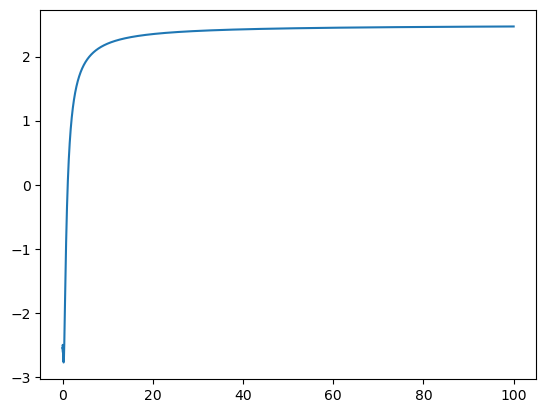

In [210]:
epsilon = 1e-5
Delta = 0.5
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_plus_vals = vq_plus(Interval_q, Delta)
plt.plot(Interval_q, q_plus_vals)

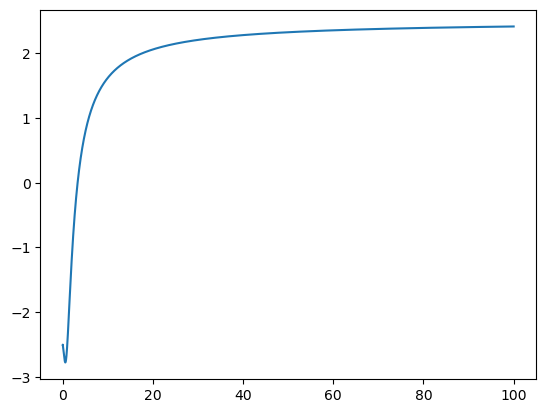

In [10]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_minus_vals = vq_minus(Interval_q, Delta)
plt.plot(Interval_q, q_minus_vals)

In [11]:
Q_plus = dict(zip(Interval_q, q_plus_vals))
Q_minus = dict(zip(Interval_q, q_minus_vals))

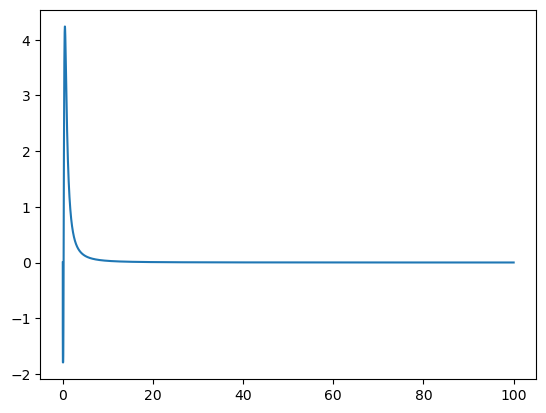

In [12]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_plus_vals = vdq_plus(Interval_q, Delta)
plt.plot(Interval_q, dq_plus_vals)

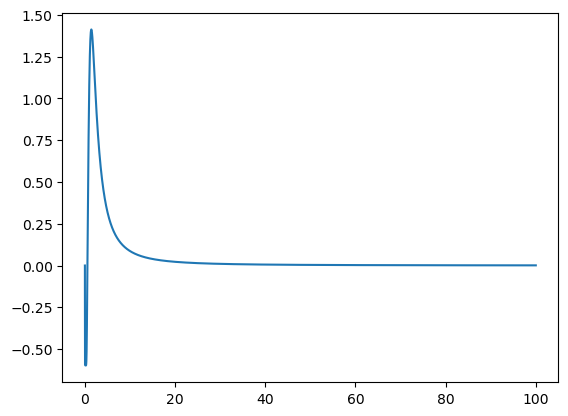

In [13]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_minus_vals = vdq_minus(Interval_q, Delta)
plt.plot(Interval_q, dq_minus_vals)

In [14]:
dQ_plus = dict(zip(Interval_q, dq_plus_vals))
dQ_minus = dict(zip(Interval_q, dq_minus_vals))

In [15]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
vfind_nearest = np.vectorize(find_nearest)

In [16]:
def q_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_plus[r_approx]

def q_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_minus[r_approx]

vq_plus_new = np.vectorize(q_plus_new)
vq_minus_new = np.vectorize(q_minus_new)

def dq_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_plus[r_approx]

def dq_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_minus[r_approx]

vdq_plus_new = np.vectorize(dq_plus_new)
vdq_minus_new = np.vectorize(dq_minus_new)


def R_inf(vq_plus, vq_minus, Delta):
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return 0.5 * (1 - mean_vq_plus) ** 2 + 0.5 * (1 + mean_vq_minus) ** 2

def grad_R_inf(r, vq_plus, vq_minus, dplus, dminus, Delta):
    J = len(r)
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return -1 / J * dplus * (1 - mean_vq_plus) + 1 / J * dminus * (1 + mean_vq_minus)

def update(r, dt, grad):
    J = len(r)
    return J * grad * dt

In [44]:
#simulate pde
def pde_sim(kappa, d, J, epsilon = 1e-5, Delta = 0.5):
    Interval = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e4))
    separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]
    processes_count = 4
    risk = np.zeros(Interval.shape[0])
    Z = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), J).reshape(J, d)
    r = np.linalg.norm(Z, axis = 1)
    mean_dist = []
    for k in trange(len(separations)):
        dt = separations[k]
        plus = vq_plus(r, Delta)
        minus = vq_minus(r, Delta)
        dplus = vdq_plus(r, Delta)
        dminus = vdq_minus(r, Delta)
        '''
        output = parallelise(r).reshape(4,J)
        plus = output[0]
        minus = output[1]
        dplus = output[2]
        dminus = output[3]
        '''
        inf_risk = R_inf(plus, minus, Delta)
        risk[k] = inf_risk
        d = np.mean(r)
        mean_dist.append(d)
        print('Epoch: {}, dist: {}'.format(k, inf_risk))
        grad = grad_R_inf(r, plus, minus, dplus, dminus, Delta)
        r = r - (Interval[k])**(-0.25)*update(r,dt, grad)
    plus = vq_plus(r, Delta)
    minus = vq_minus(r, Delta)
    inf_risk = R_inf(plus, minus, Delta)
    risk[-1] = inf_risk
    mean_dist.append(np.mean(r))
    return risk, mean_dist

In [357]:
pde_risk_1, mean_dist_pde_1 = pde_sim(0.1, 320, 2, epsilon = 1e-5, Delta = 0.5)
pde_risk_4, mean_dist_pde_4 = pde_sim(0.4, 320, 2, epsilon = 1e-5, Delta = 0.5)

  0%|          | 0/9999 [00:00<?, ?it/s]

Epoch: 0, dist: 7.937654541092151
Epoch: 1, dist: 7.93765453663114
Epoch: 2, dist: 7.937654532161646
Epoch: 3, dist: 7.937654527683652
Epoch: 4, dist: 7.937654523197142
Epoch: 5, dist: 7.937654518702102
Epoch: 6, dist: 7.937654514198512
Epoch: 7, dist: 7.937654509686361
Epoch: 8, dist: 7.937654505165628
Epoch: 9, dist: 7.937654500636297
Epoch: 10, dist: 7.937654496098355
Epoch: 11, dist: 7.93765449155178
Epoch: 12, dist: 7.937654486996562
Epoch: 13, dist: 7.9376544824326825
Epoch: 14, dist: 7.937654477860123
Epoch: 15, dist: 7.937654473278869
Epoch: 16, dist: 7.937654468688901
Epoch: 17, dist: 7.9376544640902065
Epoch: 18, dist: 7.937654459482765
Epoch: 19, dist: 7.937654454866566
Epoch: 20, dist: 7.937654450241584
Epoch: 21, dist: 7.937654445607809
Epoch: 22, dist: 7.937654440965222
Epoch: 23, dist: 7.937654436313805
Epoch: 24, dist: 7.937654431653547
Epoch: 25, dist: 7.937654426984423
Epoch: 26, dist: 7.937654422306421
Epoch: 27, dist: 7.937654417619522
Epoch: 28, dist: 7.93765441292

Epoch: 235, dist: 7.937653220901266
Epoch: 236, dist: 7.937653213929741
Epoch: 237, dist: 7.937653206944958
Epoch: 238, dist: 7.937653199946892
Epoch: 239, dist: 7.937653192935522
Epoch: 240, dist: 7.937653185910816
Epoch: 241, dist: 7.937653178872752
Epoch: 242, dist: 7.937653171821304
Epoch: 243, dist: 7.937653164756446
Epoch: 244, dist: 7.937653157678157
Epoch: 245, dist: 7.9376531505864065
Epoch: 246, dist: 7.9376531434811675
Epoch: 247, dist: 7.937653136362418
Epoch: 248, dist: 7.937653129230132
Epoch: 249, dist: 7.937653122084282
Epoch: 250, dist: 7.937653114924846
Epoch: 251, dist: 7.937653107751792
Epoch: 252, dist: 7.937653100565099
Epoch: 253, dist: 7.937653093364741
Epoch: 254, dist: 7.937653086150688
Epoch: 255, dist: 7.937653078922917
Epoch: 256, dist: 7.937653071681402
Epoch: 257, dist: 7.937653064426116
Epoch: 258, dist: 7.937653057157032
Epoch: 259, dist: 7.937653049874127
Epoch: 260, dist: 7.937653042577371
Epoch: 261, dist: 7.9376530352667425
Epoch: 262, dist: 7.93765

Epoch: 470, dist: 7.937651157749247
Epoch: 471, dist: 7.937651146854371
Epoch: 472, dist: 7.9376511359387765
Epoch: 473, dist: 7.937651125002423
Epoch: 474, dist: 7.937651114045277
Epoch: 475, dist: 7.9376511030672905
Epoch: 476, dist: 7.937651092068428
Epoch: 477, dist: 7.937651081048653
Epoch: 478, dist: 7.93765107000792
Epoch: 479, dist: 7.9376510589461935
Epoch: 480, dist: 7.93765104786343
Epoch: 481, dist: 7.937651036759592
Epoch: 482, dist: 7.937651025634636
Epoch: 483, dist: 7.9376510144885275
Epoch: 484, dist: 7.937651003321223
Epoch: 485, dist: 7.937650992132682
Epoch: 486, dist: 7.9376509809228635
Epoch: 487, dist: 7.937650969691729
Epoch: 488, dist: 7.937650958439237
Epoch: 489, dist: 7.9376509471653485
Epoch: 490, dist: 7.937650935870018
Epoch: 491, dist: 7.937650924553209
Epoch: 492, dist: 7.937650913214881
Epoch: 493, dist: 7.9376509018549894
Epoch: 494, dist: 7.937650890473499
Epoch: 495, dist: 7.937650879070364
Epoch: 496, dist: 7.937650867645543
Epoch: 497, dist: 7.937

Epoch: 699, dist: 7.937648035001425
Epoch: 700, dist: 7.937648018168236
Epoch: 701, dist: 7.937648001303036
Epoch: 702, dist: 7.937647984405765
Epoch: 703, dist: 7.937647967476362
Epoch: 704, dist: 7.937647950514765
Epoch: 705, dist: 7.937647933520914
Epoch: 706, dist: 7.937647916494747
Epoch: 707, dist: 7.937647899436203
Epoch: 708, dist: 7.9376478823452175
Epoch: 709, dist: 7.9376478652217335
Epoch: 710, dist: 7.937647848065685
Epoch: 711, dist: 7.937647830877015
Epoch: 712, dist: 7.937647813655657
Epoch: 713, dist: 7.937647796401548
Epoch: 714, dist: 7.937647779114631
Epoch: 715, dist: 7.937647761794839
Epoch: 716, dist: 7.937647744442114
Epoch: 717, dist: 7.937647727056388
Epoch: 718, dist: 7.9376477096376
Epoch: 719, dist: 7.937647692185691
Epoch: 720, dist: 7.937647674700591
Epoch: 721, dist: 7.937647657182243
Epoch: 722, dist: 7.937647639630582
Epoch: 723, dist: 7.937647622045542
Epoch: 724, dist: 7.937647604427065
Epoch: 725, dist: 7.937647586775083
Epoch: 726, dist: 7.93764756

Epoch: 963, dist: 7.937642269841736
Epoch: 964, dist: 7.937642242045335
Epoch: 965, dist: 7.937642214196076
Epoch: 966, dist: 7.93764218629386
Epoch: 967, dist: 7.9376421583385826
Epoch: 968, dist: 7.937642130330143
Epoch: 969, dist: 7.937642102268444
Epoch: 970, dist: 7.937642074153381
Epoch: 971, dist: 7.937642045984855
Epoch: 972, dist: 7.937642017762761
Epoch: 973, dist: 7.937641989486998
Epoch: 974, dist: 7.937641961157466
Epoch: 975, dist: 7.9376419327740635
Epoch: 976, dist: 7.937641904336685
Epoch: 977, dist: 7.937641875845228
Epoch: 978, dist: 7.93764184729959
Epoch: 979, dist: 7.937641818699671
Epoch: 980, dist: 7.937641790045364
Epoch: 981, dist: 7.937641761336568
Epoch: 982, dist: 7.937641732573178
Epoch: 983, dist: 7.93764170375509
Epoch: 984, dist: 7.937641674882201
Epoch: 985, dist: 7.937641645954407
Epoch: 986, dist: 7.937641616971601
Epoch: 987, dist: 7.937641587933682
Epoch: 988, dist: 7.937641558840543
Epoch: 989, dist: 7.93764152969208
Epoch: 990, dist: 7.9376415004

Epoch: 1224, dist: 7.937632887092124
Epoch: 1225, dist: 7.937632841453167
Epoch: 1226, dist: 7.937632795727423
Epoch: 1227, dist: 7.937632749914726
Epoch: 1228, dist: 7.937632704014909
Epoch: 1229, dist: 7.937632658027807
Epoch: 1230, dist: 7.937632611953256
Epoch: 1231, dist: 7.937632565791085
Epoch: 1232, dist: 7.9376325195411335
Epoch: 1233, dist: 7.9376324732032275
Epoch: 1234, dist: 7.937632426777208
Epoch: 1235, dist: 7.937632380262901
Epoch: 1236, dist: 7.93763233366014
Epoch: 1237, dist: 7.937632286968759
Epoch: 1238, dist: 7.937632240188589
Epoch: 1239, dist: 7.937632193319461
Epoch: 1240, dist: 7.937632146361201
Epoch: 1241, dist: 7.937632099313646
Epoch: 1242, dist: 7.937632052176621
Epoch: 1243, dist: 7.937632004949963
Epoch: 1244, dist: 7.937631957633493
Epoch: 1245, dist: 7.937631910227045
Epoch: 1246, dist: 7.93763186273045
Epoch: 1247, dist: 7.937631815143533
Epoch: 1248, dist: 7.9376317674661205
Epoch: 1249, dist: 7.937631719698042
Epoch: 1250, dist: 7.9376316718391315

Epoch: 1464, dist: 7.9376190227199
Epoch: 1465, dist: 7.9376189507159385
Epoch: 1466, dist: 7.937618878575051
Epoch: 1467, dist: 7.937618806296976
Epoch: 1468, dist: 7.937618733881456
Epoch: 1469, dist: 7.9376186613282265
Epoch: 1470, dist: 7.937618588637027
Epoch: 1471, dist: 7.937618515807595
Epoch: 1472, dist: 7.937618442839668
Epoch: 1473, dist: 7.9376183697329825
Epoch: 1474, dist: 7.937618296487274
Epoch: 1475, dist: 7.93761822310228
Epoch: 1476, dist: 7.937618149577733
Epoch: 1477, dist: 7.937618075913367
Epoch: 1478, dist: 7.937618002108921
Epoch: 1479, dist: 7.937617928164123
Epoch: 1480, dist: 7.937617854078711
Epoch: 1481, dist: 7.937617779852413
Epoch: 1482, dist: 7.937617705484967
Epoch: 1483, dist: 7.937617630976097
Epoch: 1484, dist: 7.937617556325538
Epoch: 1485, dist: 7.937617481533023
Epoch: 1486, dist: 7.937617406598278
Epoch: 1487, dist: 7.937617331521035
Epoch: 1488, dist: 7.937617256301023
Epoch: 1489, dist: 7.937617180937967
Epoch: 1490, dist: 7.937617105431601
E

Epoch: 1725, dist: 7.9375947175617005
Epoch: 1726, dist: 7.937594599338013
Epoch: 1727, dist: 7.937594480889503
Epoch: 1728, dist: 7.93759436221575
Epoch: 1729, dist: 7.937594243316317
Epoch: 1730, dist: 7.93759412419078
Epoch: 1731, dist: 7.93759400483871
Epoch: 1732, dist: 7.937593885259673
Epoch: 1733, dist: 7.93759376545324
Epoch: 1734, dist: 7.9375936454189775
Epoch: 1735, dist: 7.937593525156453
Epoch: 1736, dist: 7.937593404665231
Epoch: 1737, dist: 7.937593283944876
Epoch: 1738, dist: 7.937593162994957
Epoch: 1739, dist: 7.937593041815031
Epoch: 1740, dist: 7.937592920404661
Epoch: 1741, dist: 7.937592798763416
Epoch: 1742, dist: 7.937592676890851
Epoch: 1743, dist: 7.937592554786528
Epoch: 1744, dist: 7.937592432450003
Epoch: 1745, dist: 7.937592309880841
Epoch: 1746, dist: 7.937592187078595
Epoch: 1747, dist: 7.93759206404282
Epoch: 1748, dist: 7.937591940773075
Epoch: 1749, dist: 7.937591817268915
Epoch: 1750, dist: 7.937591693529894
Epoch: 1751, dist: 7.937591569555567
Epoc

Epoch: 1992, dist: 7.937553640520597
Epoch: 1993, dist: 7.937553444182672
Epoch: 1994, dist: 7.93755324747138
Epoch: 1995, dist: 7.9375530503860094
Epoch: 1996, dist: 7.937552852925851
Epoch: 1997, dist: 7.93755265509019
Epoch: 1998, dist: 7.937552456878316
Epoch: 1999, dist: 7.937552258289507
Epoch: 2000, dist: 7.937552059323052
Epoch: 2001, dist: 7.937551859978231
Epoch: 2002, dist: 7.937551660254323
Epoch: 2003, dist: 7.937551460150608
Epoch: 2004, dist: 7.937551259666366
Epoch: 2005, dist: 7.937551058800871
Epoch: 2006, dist: 7.937550857553399
Epoch: 2007, dist: 7.93755065592322
Epoch: 2008, dist: 7.937550453909612
Epoch: 2009, dist: 7.937550251511842
Epoch: 2010, dist: 7.937550048729181
Epoch: 2011, dist: 7.937549845560896
Epoch: 2012, dist: 7.937549642006255
Epoch: 2013, dist: 7.93754943806452
Epoch: 2014, dist: 7.937549233734961
Epoch: 2015, dist: 7.937549029016836
Epoch: 2016, dist: 7.937548823909405
Epoch: 2017, dist: 7.937548618411931
Epoch: 2018, dist: 7.93754841252367
Epoch

Epoch: 2257, dist: 7.9374860726823755
Epoch: 2258, dist: 7.937485747852902
Epoch: 2259, dist: 7.937485422405706
Epoch: 2260, dist: 7.937485096339616
Epoch: 2261, dist: 7.937484769653453
Epoch: 2262, dist: 7.9374844423460384
Epoch: 2263, dist: 7.937484114416192
Epoch: 2264, dist: 7.937483785862727
Epoch: 2265, dist: 7.93748345668446
Epoch: 2266, dist: 7.937483126880201
Epoch: 2267, dist: 7.937482796448764
Epoch: 2268, dist: 7.937482465388947
Epoch: 2269, dist: 7.9374821336995645
Epoch: 2270, dist: 7.937481801379417
Epoch: 2271, dist: 7.937481468427302
Epoch: 2272, dist: 7.93748113484202
Epoch: 2273, dist: 7.937480800622366
Epoch: 2274, dist: 7.937480465767133
Epoch: 2275, dist: 7.937480130275114
Epoch: 2276, dist: 7.937479794145096
Epoch: 2277, dist: 7.937479457375868
Epoch: 2278, dist: 7.937479119966211
Epoch: 2279, dist: 7.937478781914911
Epoch: 2280, dist: 7.937478443220745
Epoch: 2281, dist: 7.937478103882492
Epoch: 2282, dist: 7.937477763898928
Epoch: 2283, dist: 7.937477423268822


Epoch: 2523, dist: 7.937373747914448
Epoch: 2524, dist: 7.937373209477787
Epoch: 2525, dist: 7.937372670017178
Epoch: 2526, dist: 7.937372129530674
Epoch: 2527, dist: 7.937371588016319
Epoch: 2528, dist: 7.937371045472162
Epoch: 2529, dist: 7.937370501896244
Epoch: 2530, dist: 7.937369957286604
Epoch: 2531, dist: 7.937369411641275
Epoch: 2532, dist: 7.937368864958284
Epoch: 2533, dist: 7.937368317235663
Epoch: 2534, dist: 7.93736776847143
Epoch: 2535, dist: 7.937367218663609
Epoch: 2536, dist: 7.937366667810213
Epoch: 2537, dist: 7.937366115909253
Epoch: 2538, dist: 7.937365562958737
Epoch: 2539, dist: 7.937365008956668
Epoch: 2540, dist: 7.93736445390105
Epoch: 2541, dist: 7.937363897789874
Epoch: 2542, dist: 7.937363340621136
Epoch: 2543, dist: 7.937362782392825
Epoch: 2544, dist: 7.937362223102923
Epoch: 2545, dist: 7.937361662749415
Epoch: 2546, dist: 7.937361101330274
Epoch: 2547, dist: 7.937360538843477
Epoch: 2548, dist: 7.937359975286991
Epoch: 2549, dist: 7.937359410658785
Epo

Epoch: 2784, dist: 7.937191994862626
Epoch: 2785, dist: 7.937191110780046
Epoch: 2786, dist: 7.937190225016152
Epoch: 2787, dist: 7.937189337567751
Epoch: 2788, dist: 7.937188448431633
Epoch: 2789, dist: 7.937187557604593
Epoch: 2790, dist: 7.937186665083414
Epoch: 2791, dist: 7.937185770864874
Epoch: 2792, dist: 7.937184874945743
Epoch: 2793, dist: 7.937183977322788
Epoch: 2794, dist: 7.937183077992771
Epoch: 2795, dist: 7.937182176952439
Epoch: 2796, dist: 7.937181274198546
Epoch: 2797, dist: 7.937180369727827
Epoch: 2798, dist: 7.937179463537023
Epoch: 2799, dist: 7.937178555622857
Epoch: 2800, dist: 7.937177645982057
Epoch: 2801, dist: 7.937176734611332
Epoch: 2802, dist: 7.937175821507396
Epoch: 2803, dist: 7.9371749066669555
Epoch: 2804, dist: 7.937173990086703
Epoch: 2805, dist: 7.937173071763331
Epoch: 2806, dist: 7.937172151693523
Epoch: 2807, dist: 7.93717122987396
Epoch: 2808, dist: 7.937170306301314
Epoch: 2809, dist: 7.937169380972249
Epoch: 2810, dist: 7.937168453883426
E

Epoch: 3006, dist: 7.9369480794465765
Epoch: 3007, dist: 7.936946731487414
Epoch: 3008, dist: 7.9369453809646675
Epoch: 3009, dist: 7.9369440278734595
Epoch: 3010, dist: 7.9369426722089065
Epoch: 3011, dist: 7.936941313966111
Epoch: 3012, dist: 7.936939953140173
Epoch: 3013, dist: 7.936938589726178
Epoch: 3014, dist: 7.9369372237192035
Epoch: 3015, dist: 7.9369358551143145
Epoch: 3016, dist: 7.936934483906573
Epoch: 3017, dist: 7.936933110091029
Epoch: 3018, dist: 7.93693173366272
Epoch: 3019, dist: 7.936930354616677
Epoch: 3020, dist: 7.936928972947923
Epoch: 3021, dist: 7.936927588651469
Epoch: 3022, dist: 7.936926201722314
Epoch: 3023, dist: 7.936924812155452
Epoch: 3024, dist: 7.936923419945867
Epoch: 3025, dist: 7.936922025088533
Epoch: 3026, dist: 7.936920627578412
Epoch: 3027, dist: 7.93691922741046
Epoch: 3028, dist: 7.936917824579618
Epoch: 3029, dist: 7.936916419080828
Epoch: 3030, dist: 7.93691501090901
Epoch: 3031, dist: 7.936913600059081
Epoch: 3032, dist: 7.93691218652594

Epoch: 3278, dist: 7.936468477639904
Epoch: 3279, dist: 7.936466217530141
Epoch: 3280, dist: 7.93646395312175
Epoch: 3281, dist: 7.9364616844065505
Epoch: 3282, dist: 7.936459411376349
Epoch: 3283, dist: 7.936457134022943
Epoch: 3284, dist: 7.936454852338101
Epoch: 3285, dist: 7.936452566313589
Epoch: 3286, dist: 7.93645027594115
Epoch: 3287, dist: 7.936447981212509
Epoch: 3288, dist: 7.9364456821193885
Epoch: 3289, dist: 7.936443378653478
Epoch: 3290, dist: 7.9364410708064606
Epoch: 3291, dist: 7.936438758570005
Epoch: 3292, dist: 7.9364364419357605
Epoch: 3293, dist: 7.936434120895358
Epoch: 3294, dist: 7.93643179544042
Epoch: 3295, dist: 7.9364294655625445
Epoch: 3296, dist: 7.936427131253323
Epoch: 3297, dist: 7.936424792504321
Epoch: 3298, dist: 7.936422449307096
Epoch: 3299, dist: 7.936420101653182
Epoch: 3300, dist: 7.936417749534105
Epoch: 3301, dist: 7.936415392941371
Epoch: 3302, dist: 7.93641303186647
Epoch: 3303, dist: 7.936410666300868
Epoch: 3304, dist: 7.936408296236035


Epoch: 3541, dist: 7.935698100728529
Epoch: 3542, dist: 7.935694375317585
Epoch: 3543, dist: 7.9356906428203215
Epoch: 3544, dist: 7.935686903223254
Epoch: 3545, dist: 7.9356831565128765
Epoch: 3546, dist: 7.935679402675654
Epoch: 3547, dist: 7.9356756416980225
Epoch: 3548, dist: 7.9356718735664025
Epoch: 3549, dist: 7.935668098267176
Epoch: 3550, dist: 7.935664315786711
Epoch: 3551, dist: 7.93566052611134
Epoch: 3552, dist: 7.935656729227375
Epoch: 3553, dist: 7.935652925121104
Epoch: 3554, dist: 7.935649113778778
Epoch: 3555, dist: 7.935645295186634
Epoch: 3556, dist: 7.935641469330878
Epoch: 3557, dist: 7.935637636197687
Epoch: 3558, dist: 7.935633795773214
Epoch: 3559, dist: 7.935629948043589
Epoch: 3560, dist: 7.935626092994913
Epoch: 3561, dist: 7.935622230613255
Epoch: 3562, dist: 7.935618360884668
Epoch: 3563, dist: 7.93561448379517
Epoch: 3564, dist: 7.935610599330758
Epoch: 3565, dist: 7.9356067074773975
Epoch: 3566, dist: 7.935602808221028
Epoch: 3567, dist: 7.93559890154756

Epoch: 3806, dist: 7.934415927415173
Epoch: 3807, dist: 7.934409762903328
Epoch: 3808, dist: 7.9344035866636515
Epoch: 3809, dist: 7.934397398673824
Epoch: 3810, dist: 7.934391198911489
Epoch: 3811, dist: 7.9343849873542345
Epoch: 3812, dist: 7.9343787639796135
Epoch: 3813, dist: 7.934372528765136
Epoch: 3814, dist: 7.9343662816882645
Epoch: 3815, dist: 7.934360022726423
Epoch: 3816, dist: 7.934353751856994
Epoch: 3817, dist: 7.934347469057309
Epoch: 3818, dist: 7.934341174304667
Epoch: 3819, dist: 7.9343348675763155
Epoch: 3820, dist: 7.934328548849459
Epoch: 3821, dist: 7.934322218101266
Epoch: 3822, dist: 7.934315875308851
Epoch: 3823, dist: 7.934309520449296
Epoch: 3824, dist: 7.934303153499631
Epoch: 3825, dist: 7.934296774436842
Epoch: 3826, dist: 7.934290383237882
Epoch: 3827, dist: 7.934283979879645
Epoch: 3828, dist: 7.934277564338992
Epoch: 3829, dist: 7.934271136592734
Epoch: 3830, dist: 7.934264696617642
Epoch: 3831, dist: 7.934258244390442
Epoch: 3832, dist: 7.934251779887

Epoch: 4075, dist: 7.93225325538096
Epoch: 4076, dist: 7.932242975909764
Epoch: 4077, dist: 7.932232676877185
Epoch: 4078, dist: 7.932222358245974
Epoch: 4079, dist: 7.932212019978814
Epoch: 4080, dist: 7.932201662038317
Epoch: 4081, dist: 7.932191284387019
Epoch: 4082, dist: 7.932180886987393
Epoch: 4083, dist: 7.9321704698018385
Epoch: 4084, dist: 7.932160032792673
Epoch: 4085, dist: 7.932149575922159
Epoch: 4086, dist: 7.932139099152474
Epoch: 4087, dist: 7.932128602445728
Epoch: 4088, dist: 7.932118085763959
Epoch: 4089, dist: 7.932107549069132
Epoch: 4090, dist: 7.932096992323141
Epoch: 4091, dist: 7.9320864154878015
Epoch: 4092, dist: 7.932075818524866
Epoch: 4093, dist: 7.932065201396007
Epoch: 4094, dist: 7.932054564062826
Epoch: 4095, dist: 7.932043906486849
Epoch: 4096, dist: 7.932033228629533
Epoch: 4097, dist: 7.932022530452261
Epoch: 4098, dist: 7.932011811916336
Epoch: 4099, dist: 7.932001072982998
Epoch: 4100, dist: 7.931990313613401
Epoch: 4101, dist: 7.931979533768633


Epoch: 4331, dist: 7.928866591696103
Epoch: 4332, dist: 7.9288498664516
Epoch: 4333, dist: 7.928833109369207
Epoch: 4334, dist: 7.928816320388273
Epoch: 4335, dist: 7.928799499448031
Epoch: 4336, dist: 7.928782646487592
Epoch: 4337, dist: 7.928765761445965
Epoch: 4338, dist: 7.928748844262032
Epoch: 4339, dist: 7.928731894874556
Epoch: 4340, dist: 7.928714913222193
Epoch: 4341, dist: 7.9286978992434785
Epoch: 4342, dist: 7.928680852876825
Epoch: 4343, dist: 7.928663774060538
Epoch: 4344, dist: 7.928646662732791
Epoch: 4345, dist: 7.928629518831654
Epoch: 4346, dist: 7.928612342295071
Epoch: 4347, dist: 7.9285951330608695
Epoch: 4348, dist: 7.928577891066761
Epoch: 4349, dist: 7.928560616250331
Epoch: 4350, dist: 7.928543308549056
Epoch: 4351, dist: 7.928525967900283
Epoch: 4352, dist: 7.928508594241249
Epoch: 4353, dist: 7.9284911875090645
Epoch: 4354, dist: 7.928473747640722
Epoch: 4355, dist: 7.928456274573096
Epoch: 4356, dist: 7.928438768242935
Epoch: 4357, dist: 7.928421228586878


Epoch: 4553, dist: 7.924251056022541
Epoch: 4554, dist: 7.924225543207484
Epoch: 4555, dist: 7.9241999818109825
Epoch: 4556, dist: 7.924174371740458
Epoch: 4557, dist: 7.924148712903159
Epoch: 4558, dist: 7.924123005206157
Epoch: 4559, dist: 7.9240972485563415
Epoch: 4560, dist: 7.92407144286043
Epoch: 4561, dist: 7.924045588024957
Epoch: 4562, dist: 7.924019683956287
Epoch: 4563, dist: 7.923993730560598
Epoch: 4564, dist: 7.92396772774389
Epoch: 4565, dist: 7.923941675411992
Epoch: 4566, dist: 7.92391557347054
Epoch: 4567, dist: 7.923889421825003
Epoch: 4568, dist: 7.923863220380662
Epoch: 4569, dist: 7.92383696904262
Epoch: 4570, dist: 7.9238106677158004
Epoch: 4571, dist: 7.923784316304944
Epoch: 4572, dist: 7.9237579147146056
Epoch: 4573, dist: 7.923731462849168
Epoch: 4574, dist: 7.923704960612823
Epoch: 4575, dist: 7.923678407909583
Epoch: 4576, dist: 7.92365180464328
Epoch: 4577, dist: 7.9236251507175535
Epoch: 4578, dist: 7.923598446035873
Epoch: 4579, dist: 7.923571690501517
E

Epoch: 4790, dist: 7.916618311806955
Epoch: 4791, dist: 7.916578262574236
Epoch: 4792, dist: 7.916538137061526
Epoch: 4793, dist: 7.91649793512351
Epoch: 4794, dist: 7.916457656614599
Epoch: 4795, dist: 7.916417301388925
Epoch: 4796, dist: 7.9163768693003425
Epoch: 4797, dist: 7.91633636020243
Epoch: 4798, dist: 7.916295773948488
Epoch: 4799, dist: 7.916255110391534
Epoch: 4800, dist: 7.916214369384309
Epoch: 4801, dist: 7.916173550779276
Epoch: 4802, dist: 7.916132654428614
Epoch: 4803, dist: 7.916091680184226
Epoch: 4804, dist: 7.916050627897726
Epoch: 4805, dist: 7.916009497420451
Epoch: 4806, dist: 7.915968288603455
Epoch: 4807, dist: 7.91592700129751
Epoch: 4808, dist: 7.915885635353103
Epoch: 4809, dist: 7.915844190620432
Epoch: 4810, dist: 7.915802666949422
Epoch: 4811, dist: 7.915761064189705
Epoch: 4812, dist: 7.915719382190623
Epoch: 4813, dist: 7.915677620801242
Epoch: 4814, dist: 7.915635779870334
Epoch: 4815, dist: 7.91559385924639
Epoch: 4816, dist: 7.915551858777601
Epoc

Epoch: 5062, dist: 7.90236317113517
Epoch: 5063, dist: 7.9022959738654635
Epoch: 5064, dist: 7.90222864865902
Epoch: 5065, dist: 7.902161195272793
Epoch: 5066, dist: 7.9020936134632835
Epoch: 5067, dist: 7.9020259029865265
Epoch: 5068, dist: 7.901958063598105
Epoch: 5069, dist: 7.901890095053139
Epoch: 5070, dist: 7.9018219971062935
Epoch: 5071, dist: 7.90175376951176
Epoch: 5072, dist: 7.901685412023284
Epoch: 5073, dist: 7.901616924394135
Epoch: 5074, dist: 7.901548306377122
Epoch: 5075, dist: 7.9014795577245955
Epoch: 5076, dist: 7.901410678188433
Epoch: 5077, dist: 7.901341667520046
Epoch: 5078, dist: 7.9012725254703815
Epoch: 5079, dist: 7.90120325178992
Epoch: 5080, dist: 7.901133846228668
Epoch: 5081, dist: 7.901064308536168
Epoch: 5082, dist: 7.900994638461489
Epoch: 5083, dist: 7.900924835753225
Epoch: 5084, dist: 7.900854900159502
Epoch: 5085, dist: 7.900784831427973
Epoch: 5086, dist: 7.900714629305814
Epoch: 5087, dist: 7.900644293539734
Epoch: 5088, dist: 7.900573823875952

Epoch: 5332, dist: 7.87867610871597
Epoch: 5333, dist: 7.878563862595561
Epoch: 5334, dist: 7.87845140330227
Epoch: 5335, dist: 7.878338730434634
Epoch: 5336, dist: 7.878225843590473
Epoch: 5337, dist: 7.878112742366846
Epoch: 5338, dist: 7.877999426360093
Epoch: 5339, dist: 7.877885895165804
Epoch: 5340, dist: 7.877772148378829
Epoch: 5341, dist: 7.877658185593276
Epoch: 5342, dist: 7.877544006402508
Epoch: 5343, dist: 7.877429610399142
Epoch: 5344, dist: 7.87731499717505
Epoch: 5345, dist: 7.877200166321359
Epoch: 5346, dist: 7.877085117428436
Epoch: 5347, dist: 7.87696985008591
Epoch: 5348, dist: 7.876854363882655
Epoch: 5349, dist: 7.876738658406785
Epoch: 5350, dist: 7.876622733245668
Epoch: 5351, dist: 7.876506587985912
Epoch: 5352, dist: 7.87639022221337
Epoch: 5353, dist: 7.876273635513138
Epoch: 5354, dist: 7.876156827469548
Epoch: 5355, dist: 7.876039797666175
Epoch: 5356, dist: 7.8759225456858335
Epoch: 5357, dist: 7.87580507111057
Epoch: 5358, dist: 7.875687373521668
Epoch:

Epoch: 5590, dist: 7.8413684311878304
Epoch: 5591, dist: 7.841185548259536
Epoch: 5592, dist: 7.841002320241936
Epoch: 5593, dist: 7.840818746495995
Epoch: 5594, dist: 7.8406348263815495
Epoch: 5595, dist: 7.840450559257293
Epoch: 5596, dist: 7.840265944480787
Epoch: 5597, dist: 7.840080981408459
Epoch: 5598, dist: 7.8398956693955855
Epoch: 5599, dist: 7.8397100077963096
Epoch: 5600, dist: 7.83952399596363
Epoch: 5601, dist: 7.839337633249393
Epoch: 5602, dist: 7.839150919004303
Epoch: 5603, dist: 7.838963852577913
Epoch: 5604, dist: 7.8387764333186265
Epoch: 5605, dist: 7.83858866057369
Epoch: 5606, dist: 7.838400533689195
Epoch: 5607, dist: 7.838212052010081
Epoch: 5608, dist: 7.838023214880118
Epoch: 5609, dist: 7.837834021641925
Epoch: 5610, dist: 7.837644471636951
Epoch: 5611, dist: 7.837454564205487
Epoch: 5612, dist: 7.837264298686652
Epoch: 5613, dist: 7.837073674418397
Epoch: 5614, dist: 7.836882690737499
Epoch: 5615, dist: 7.83669134697957
Epoch: 5616, dist: 7.836499642479042

Epoch: 5857, dist: 7.778023113766975
Epoch: 5858, dist: 7.777721419253752
Epoch: 5859, dist: 7.777419162171007
Epoch: 5860, dist: 7.777116341498947
Epoch: 5861, dist: 7.77681295621602
Epoch: 5862, dist: 7.776509005298893
Epoch: 5863, dist: 7.776204487722459
Epoch: 5864, dist: 7.775899402459831
Epoch: 5865, dist: 7.77559374848234
Epoch: 5866, dist: 7.775287524759528
Epoch: 5867, dist: 7.774980730259156
Epoch: 5868, dist: 7.774673363947186
Epoch: 5869, dist: 7.774365424787787
Epoch: 5870, dist: 7.774056911743335
Epoch: 5871, dist: 7.773747823774402
Epoch: 5872, dist: 7.77343815983976
Epoch: 5873, dist: 7.773127918896368
Epoch: 5874, dist: 7.772817099899381
Epoch: 5875, dist: 7.772505701802143
Epoch: 5876, dist: 7.77219372355618
Epoch: 5877, dist: 7.7718811641112
Epoch: 5878, dist: 7.7715680224150905
Epoch: 5879, dist: 7.771254297413915
Epoch: 5880, dist: 7.770939988051909
Epoch: 5881, dist: 7.77062509327148
Epoch: 5882, dist: 7.770309612013199
Epoch: 5883, dist: 7.769993543215803
Epoch: 

Epoch: 6121, dist: 7.675372276795078
Epoch: 6122, dist: 7.674880691575945
Epoch: 6123, dist: 7.674388203864785
Epoch: 6124, dist: 7.673894812068756
Epoch: 6125, dist: 7.673400514592458
Epoch: 6126, dist: 7.672905309837918
Epoch: 6127, dist: 7.672409196204592
Epoch: 6128, dist: 7.671912172089371
Epoch: 6129, dist: 7.671414235886564
Epoch: 6130, dist: 7.670915385987907
Epoch: 6131, dist: 7.670415620782549
Epoch: 6132, dist: 7.6699149386570635
Epoch: 6133, dist: 7.66941333799543
Epoch: 6134, dist: 7.668910817179048
Epoch: 6135, dist: 7.668407374586719
Epoch: 6136, dist: 7.667903008594649
Epoch: 6137, dist: 7.667397717576452
Epoch: 6138, dist: 7.66689149990314
Epoch: 6139, dist: 7.666384353943123
Epoch: 6140, dist: 7.665876278062207
Epoch: 6141, dist: 7.665367270623584
Epoch: 6142, dist: 7.664857329987847
Epoch: 6143, dist: 7.664346454512965
Epoch: 6144, dist: 7.663834642554299
Epoch: 6145, dist: 7.663321892464587
Epoch: 6146, dist: 7.662808202593948
Epoch: 6147, dist: 7.662293571289875
Ep

Epoch: 6394, dist: 7.501710949856275
Epoch: 6395, dist: 7.5009047695672155
Epoch: 6396, dist: 7.500097151138111
Epoch: 6397, dist: 7.499288092256249
Epoch: 6398, dist: 7.498477590607371
Epoch: 6399, dist: 7.497665643875749
Epoch: 6400, dist: 7.496852249744189
Epoch: 6401, dist: 7.496037405894093
Epoch: 6402, dist: 7.495221110005486
Epoch: 6403, dist: 7.4944033597570705
Epoch: 6404, dist: 7.493584152826258
Epoch: 6405, dist: 7.492763486889213
Epoch: 6406, dist: 7.491941359620904
Epoch: 6407, dist: 7.491117768695151
Epoch: 6408, dist: 7.490292711784667
Epoch: 6409, dist: 7.4894661865611045
Epoch: 6410, dist: 7.488638190695112
Epoch: 6411, dist: 7.487808721856389
Epoch: 6412, dist: 7.486977777713728
Epoch: 6413, dist: 7.486145355935071
Epoch: 6414, dist: 7.485311454187576
Epoch: 6415, dist: 7.484476070137663
Epoch: 6416, dist: 7.483639201451076
Epoch: 6417, dist: 7.482800845792949
Epoch: 6418, dist: 7.481961000827859
Epoch: 6419, dist: 7.4811196642198965
Epoch: 6420, dist: 7.4802768336327

Epoch: 6649, dist: 7.2620421028610025
Epoch: 6650, dist: 7.260379551301854
Epoch: 6651, dist: 7.2593071777584655
Epoch: 6652, dist: 7.259230213504509
Epoch: 6653, dist: 7.2595788066992615
Epoch: 6654, dist: 7.2587117542634765
Epoch: 6655, dist: 7.257607423115411
Epoch: 6656, dist: 7.257481917365456
Epoch: 6657, dist: 7.258497439184522
Epoch: 6658, dist: 7.258016751647172
Epoch: 6659, dist: 7.2562672456392825
Epoch: 6660, dist: 7.257853031708231
Epoch: 6661, dist: 7.258445061204418
Epoch: 6662, dist: 7.2581234945600235
Epoch: 6663, dist: 7.2577342346853975
Epoch: 6664, dist: 7.257084542189871
Epoch: 6665, dist: 7.257018256168115
Epoch: 6666, dist: 7.258548346496507
Epoch: 6667, dist: 7.257993350406321
Epoch: 6668, dist: 7.255649556918536
Epoch: 6669, dist: 7.2577766826883945
Epoch: 6670, dist: 7.255786445820348
Epoch: 6671, dist: 7.257111434384082
Epoch: 6672, dist: 7.256465530367642
Epoch: 6673, dist: 7.257048120190949
Epoch: 6674, dist: 7.257349876149588
Epoch: 6675, dist: 7.256696132

Epoch: 7018, dist: 7.254746399758681
Epoch: 7019, dist: 7.2551907843464765
Epoch: 7020, dist: 7.255154385820855
Epoch: 7021, dist: 7.255053112790039
Epoch: 7022, dist: 7.254959688563166
Epoch: 7023, dist: 7.255525886440594
Epoch: 7024, dist: 7.254869890838281
Epoch: 7025, dist: 7.255781614556349
Epoch: 7026, dist: 7.256037523578378
Epoch: 7027, dist: 7.254690615433555
Epoch: 7028, dist: 7.255612354031638
Epoch: 7029, dist: 7.255054542547187
Epoch: 7030, dist: 7.25548795898497
Epoch: 7031, dist: 7.254769897031324
Epoch: 7032, dist: 7.254337229669562
Epoch: 7033, dist: 7.254881277179783
Epoch: 7034, dist: 7.255199067979679
Epoch: 7035, dist: 7.255864522805641
Epoch: 7036, dist: 7.255463633925963
Epoch: 7037, dist: 7.254891939245171
Epoch: 7038, dist: 7.254548788185447
Epoch: 7039, dist: 7.25607522021277
Epoch: 7040, dist: 7.255131773627284
Epoch: 7041, dist: 7.254678764074499
Epoch: 7042, dist: 7.255412519625059
Epoch: 7043, dist: 7.2554490515207615
Epoch: 7044, dist: 7.255766190826089
E

Epoch: 7397, dist: 7.2548049795757175
Epoch: 7398, dist: 7.255585964440415
Epoch: 7399, dist: 7.254895889720748
Epoch: 7400, dist: 7.255656614662149
Epoch: 7401, dist: 7.254847374696922
Epoch: 7402, dist: 7.254540830418725
Epoch: 7403, dist: 7.253954866524649
Epoch: 7404, dist: 7.254516948556136
Epoch: 7405, dist: 7.254895876875375
Epoch: 7406, dist: 7.254202968760294
Epoch: 7407, dist: 7.2553481558609345
Epoch: 7408, dist: 7.255338157890129
Epoch: 7409, dist: 7.254909195336503
Epoch: 7410, dist: 7.254575270892879
Epoch: 7411, dist: 7.254301503671148
Epoch: 7412, dist: 7.254920513930832
Epoch: 7413, dist: 7.254242221406861
Epoch: 7414, dist: 7.2543039010830395
Epoch: 7415, dist: 7.255137396355615
Epoch: 7416, dist: 7.254519814399
Epoch: 7417, dist: 7.255657069357797
Epoch: 7418, dist: 7.255788531184096
Epoch: 7419, dist: 7.254982160930406
Epoch: 7420, dist: 7.2544715459997215
Epoch: 7421, dist: 7.254829728757475
Epoch: 7422, dist: 7.254422872270059
Epoch: 7423, dist: 7.255338216325006


Epoch: 7805, dist: 7.254553851900497
Epoch: 7806, dist: 7.254244365672303
Epoch: 7807, dist: 7.25475732828192
Epoch: 7808, dist: 7.254652628582066
Epoch: 7809, dist: 7.254529095155233
Epoch: 7810, dist: 7.254963586285097
Epoch: 7811, dist: 7.255330473988526
Epoch: 7812, dist: 7.25482572524406
Epoch: 7813, dist: 7.25419018302516
Epoch: 7814, dist: 7.254806257561913
Epoch: 7815, dist: 7.255027065360002
Epoch: 7816, dist: 7.254498990905063
Epoch: 7817, dist: 7.254579749699145
Epoch: 7818, dist: 7.253796148141504
Epoch: 7819, dist: 7.2548908755010615
Epoch: 7820, dist: 7.254249596824994
Epoch: 7821, dist: 7.254263445909728
Epoch: 7822, dist: 7.254788743097872
Epoch: 7823, dist: 7.255092077547382
Epoch: 7824, dist: 7.254468773364397
Epoch: 7825, dist: 7.25405475586007
Epoch: 7826, dist: 7.2547216752779615
Epoch: 7827, dist: 7.255086923329024
Epoch: 7828, dist: 7.254924475720013
Epoch: 7829, dist: 7.25483539963786
Epoch: 7830, dist: 7.254819052136038
Epoch: 7831, dist: 7.254268937987344
Epoc

Epoch: 8215, dist: 7.254393312644062
Epoch: 8216, dist: 7.255065168926664
Epoch: 8217, dist: 7.254395906330066
Epoch: 8218, dist: 7.254549685480965
Epoch: 8219, dist: 7.254570083639824
Epoch: 8220, dist: 7.254859393715532
Epoch: 8221, dist: 7.254214460609774
Epoch: 8222, dist: 7.2542521817825705
Epoch: 8223, dist: 7.254704082111466
Epoch: 8224, dist: 7.2547219511991585
Epoch: 8225, dist: 7.254254601750219
Epoch: 8226, dist: 7.254991281017252
Epoch: 8227, dist: 7.254048157693725
Epoch: 8228, dist: 7.254713694191009
Epoch: 8229, dist: 7.254582848352524
Epoch: 8230, dist: 7.254067355631413
Epoch: 8231, dist: 7.255231265247744
Epoch: 8232, dist: 7.2548882821515885
Epoch: 8233, dist: 7.2540717484272825
Epoch: 8234, dist: 7.254317148685872
Epoch: 8235, dist: 7.255470441769674
Epoch: 8236, dist: 7.2542126237089715
Epoch: 8237, dist: 7.254370890917633
Epoch: 8238, dist: 7.254600623536832
Epoch: 8239, dist: 7.255180119897285
Epoch: 8240, dist: 7.255123766102908
Epoch: 8241, dist: 7.254557359738

Epoch: 8597, dist: 7.25419584040743
Epoch: 8598, dist: 7.254423829048461
Epoch: 8599, dist: 7.254492770217279
Epoch: 8600, dist: 7.254457530779803
Epoch: 8601, dist: 7.254675311911286
Epoch: 8602, dist: 7.253764116787012
Epoch: 8603, dist: 7.25411826412224
Epoch: 8604, dist: 7.254560923350411
Epoch: 8605, dist: 7.255042515970379
Epoch: 8606, dist: 7.254196373126012
Epoch: 8607, dist: 7.253451225290122
Epoch: 8608, dist: 7.254392864837455
Epoch: 8609, dist: 7.254279675336559
Epoch: 8610, dist: 7.254323414197833
Epoch: 8611, dist: 7.253706731236823
Epoch: 8612, dist: 7.254663292711464
Epoch: 8613, dist: 7.254259907827715
Epoch: 8614, dist: 7.254704882879665
Epoch: 8615, dist: 7.254921702339143
Epoch: 8616, dist: 7.253936439838925
Epoch: 8617, dist: 7.254678777580884
Epoch: 8618, dist: 7.25436332289179
Epoch: 8619, dist: 7.254003662005674
Epoch: 8620, dist: 7.25459208272189
Epoch: 8621, dist: 7.254425526436728
Epoch: 8622, dist: 7.253917965797446
Epoch: 8623, dist: 7.254724034223576
Epoch

Epoch: 8933, dist: 7.253782684929694
Epoch: 8934, dist: 7.254152615688926
Epoch: 8935, dist: 7.254494833716075
Epoch: 8936, dist: 7.2549208216459675
Epoch: 8937, dist: 7.254295827853808
Epoch: 8938, dist: 7.254678291500731
Epoch: 8939, dist: 7.253846405311295
Epoch: 8940, dist: 7.255077387132607
Epoch: 8941, dist: 7.254329647631089
Epoch: 8942, dist: 7.254170084108774
Epoch: 8943, dist: 7.2543775809026005
Epoch: 8944, dist: 7.254415765665316
Epoch: 8945, dist: 7.254012126062329
Epoch: 8946, dist: 7.254030966916446
Epoch: 8947, dist: 7.2538857997525295
Epoch: 8948, dist: 7.253942574310023
Epoch: 8949, dist: 7.254688086973361
Epoch: 8950, dist: 7.254132266175094
Epoch: 8951, dist: 7.25423972065207
Epoch: 8952, dist: 7.254153396035689
Epoch: 8953, dist: 7.254425091936492
Epoch: 8954, dist: 7.254649986509667
Epoch: 8955, dist: 7.25408720684812
Epoch: 8956, dist: 7.254617672223197
Epoch: 8957, dist: 7.25400757910664
Epoch: 8958, dist: 7.253903606484994
Epoch: 8959, dist: 7.253901435214375
E

Epoch: 9271, dist: 7.253686504003282
Epoch: 9272, dist: 7.253626419322337
Epoch: 9273, dist: 7.2539876125495235
Epoch: 9274, dist: 7.2539562004968685
Epoch: 9275, dist: 7.253989262363304
Epoch: 9276, dist: 7.253822009077746
Epoch: 9277, dist: 7.254791150124177
Epoch: 9278, dist: 7.254211960708187
Epoch: 9279, dist: 7.254698970088109
Epoch: 9280, dist: 7.254229912711441
Epoch: 9281, dist: 7.254286952062196
Epoch: 9282, dist: 7.254570643325695
Epoch: 9283, dist: 7.253927032608108
Epoch: 9284, dist: 7.253839997274646
Epoch: 9285, dist: 7.253918617458083
Epoch: 9286, dist: 7.25408625422145
Epoch: 9287, dist: 7.254326367301688
Epoch: 9288, dist: 7.253662115091768
Epoch: 9289, dist: 7.254315722338876
Epoch: 9290, dist: 7.253892291111083
Epoch: 9291, dist: 7.2540475238822655
Epoch: 9292, dist: 7.253785416757761
Epoch: 9293, dist: 7.254124676142298
Epoch: 9294, dist: 7.254516368038432
Epoch: 9295, dist: 7.254304528161482
Epoch: 9296, dist: 7.253922483227201
Epoch: 9297, dist: 7.253632601835605

Epoch: 9629, dist: 7.253999846261239
Epoch: 9630, dist: 7.253493753967771
Epoch: 9631, dist: 7.2538197920266185
Epoch: 9632, dist: 7.254345782997163
Epoch: 9633, dist: 7.254143347480429
Epoch: 9634, dist: 7.254463100505072
Epoch: 9635, dist: 7.254059509223452
Epoch: 9636, dist: 7.2543512346848855
Epoch: 9637, dist: 7.253878603623643
Epoch: 9638, dist: 7.254034840937731
Epoch: 9639, dist: 7.254554045516398
Epoch: 9640, dist: 7.253761005278369
Epoch: 9641, dist: 7.254088827347054
Epoch: 9642, dist: 7.254242443798918
Epoch: 9643, dist: 7.254309452918408
Epoch: 9644, dist: 7.254597279685404
Epoch: 9645, dist: 7.2536737861924285
Epoch: 9646, dist: 7.253970958031339
Epoch: 9647, dist: 7.253716961708916
Epoch: 9648, dist: 7.254546299883043
Epoch: 9649, dist: 7.253759477076443
Epoch: 9650, dist: 7.253953362391387
Epoch: 9651, dist: 7.254176465235599
Epoch: 9652, dist: 7.253685924762247
Epoch: 9653, dist: 7.254150760356503
Epoch: 9654, dist: 7.2546747070573385
Epoch: 9655, dist: 7.2537436053642

  0%|          | 0/9999 [00:00<?, ?it/s]

Epoch: 0, dist: 6.745330619270984
Epoch: 1, dist: 6.7453306071565935
Epoch: 2, dist: 6.7453305950191655
Epoch: 3, dist: 6.74533058285866
Epoch: 4, dist: 6.745330570675028
Epoch: 5, dist: 6.745330558468225
Epoch: 6, dist: 6.745330546238212
Epoch: 7, dist: 6.745330533984939
Epoch: 8, dist: 6.745330521708367
Epoch: 9, dist: 6.745330509408448
Epoch: 10, dist: 6.745330497085141
Epoch: 11, dist: 6.7453304847384
Epoch: 12, dist: 6.745330472368179
Epoch: 13, dist: 6.745330459974433
Epoch: 14, dist: 6.745330447557119
Epoch: 15, dist: 6.745330435116196
Epoch: 16, dist: 6.74533042265161
Epoch: 17, dist: 6.745330410163325
Epoch: 18, dist: 6.745330397651289
Epoch: 19, dist: 6.7453303851154605
Epoch: 20, dist: 6.745330372555793
Epoch: 21, dist: 6.745330359972241
Epoch: 22, dist: 6.745330347364761
Epoch: 23, dist: 6.745330334733308
Epoch: 24, dist: 6.745330322077831
Epoch: 25, dist: 6.745330309398294
Epoch: 26, dist: 6.745330296694637
Epoch: 27, dist: 6.745330283966828
Epoch: 28, dist: 6.745330271214

Epoch: 253, dist: 6.745326687800163
Epoch: 254, dist: 6.745326668209571
Epoch: 255, dist: 6.745326648581726
Epoch: 256, dist: 6.745326628916558
Epoch: 257, dist: 6.74532660921399
Epoch: 258, dist: 6.745326589473955
Epoch: 259, dist: 6.7453265696963856
Epoch: 260, dist: 6.745326549881204
Epoch: 261, dist: 6.745326530028343
Epoch: 262, dist: 6.745326510137724
Epoch: 263, dist: 6.745326490209287
Epoch: 264, dist: 6.745326470242952
Epoch: 265, dist: 6.745326450238647
Epoch: 266, dist: 6.745326430196302
Epoch: 267, dist: 6.745326410115846
Epoch: 268, dist: 6.745326389997199
Epoch: 269, dist: 6.7453263698402965
Epoch: 270, dist: 6.7453263496450635
Epoch: 271, dist: 6.7453263294114265
Epoch: 272, dist: 6.74532630913931
Epoch: 273, dist: 6.745326288828647
Epoch: 274, dist: 6.745326268479361
Epoch: 275, dist: 6.745326248091376
Epoch: 276, dist: 6.745326227664621
Epoch: 277, dist: 6.745326207199021
Epoch: 278, dist: 6.745326186694506
Epoch: 279, dist: 6.745326166150997
Epoch: 280, dist: 6.745326

Epoch: 506, dist: 6.745320330084645
Epoch: 507, dist: 6.74532029840403
Epoch: 508, dist: 6.7453202666631675
Epoch: 509, dist: 6.745320234861946
Epoch: 510, dist: 6.745320203000253
Epoch: 511, dist: 6.745320171077968
Epoch: 512, dist: 6.745320139094982
Epoch: 513, dist: 6.745320107051173
Epoch: 514, dist: 6.745320074946433
Epoch: 515, dist: 6.745320042780636
Epoch: 516, dist: 6.745320010553674
Epoch: 517, dist: 6.74531997826543
Epoch: 518, dist: 6.7453199459157815
Epoch: 519, dist: 6.74531991350462
Epoch: 520, dist: 6.745319881031822
Epoch: 521, dist: 6.745319848497274
Epoch: 522, dist: 6.745319815900856
Epoch: 523, dist: 6.745319783242451
Epoch: 524, dist: 6.7453197505219435
Epoch: 525, dist: 6.745319717739216
Epoch: 526, dist: 6.745319684894143
Epoch: 527, dist: 6.745319651986615
Epoch: 528, dist: 6.745319619016506
Epoch: 529, dist: 6.745319585983703
Epoch: 530, dist: 6.745319552888079
Epoch: 531, dist: 6.745319519729524
Epoch: 532, dist: 6.745319486507912
Epoch: 533, dist: 6.74531945

Epoch: 744, dist: 6.745310805715143
Epoch: 745, dist: 6.745310755922686
Epoch: 746, dist: 6.745310706035545
Epoch: 747, dist: 6.745310656053537
Epoch: 748, dist: 6.745310605976479
Epoch: 749, dist: 6.745310555804192
Epoch: 750, dist: 6.745310505536497
Epoch: 751, dist: 6.745310455173212
Epoch: 752, dist: 6.7453104047141546
Epoch: 753, dist: 6.745310354159141
Epoch: 754, dist: 6.74531030350799
Epoch: 755, dist: 6.745310252760522
Epoch: 756, dist: 6.745310201916549
Epoch: 757, dist: 6.745310150975891
Epoch: 758, dist: 6.7453100999383615
Epoch: 759, dist: 6.745310048803779
Epoch: 760, dist: 6.745309997571954
Epoch: 761, dist: 6.745309946242708
Epoch: 762, dist: 6.74530989481585
Epoch: 763, dist: 6.7453098432911975
Epoch: 764, dist: 6.745309791668568
Epoch: 765, dist: 6.745309739947767
Epoch: 766, dist: 6.745309688128614
Epoch: 767, dist: 6.7453096362109175
Epoch: 768, dist: 6.745309584194497
Epoch: 769, dist: 6.7453095320791565
Epoch: 770, dist: 6.745309479864713
Epoch: 771, dist: 6.74530

Epoch: 982, dist: 6.745295836251047
Epoch: 983, dist: 6.745295757992164
Epoch: 984, dist: 6.7452956795844585
Epoch: 985, dist: 6.745295601027651
Epoch: 986, dist: 6.745295522321458
Epoch: 987, dist: 6.745295443465596
Epoch: 988, dist: 6.7452953644597775
Epoch: 989, dist: 6.745295285303717
Epoch: 990, dist: 6.745295205997135
Epoch: 991, dist: 6.745295126539738
Epoch: 992, dist: 6.745295046931242
Epoch: 993, dist: 6.745294967171361
Epoch: 994, dist: 6.745294887259806
Epoch: 995, dist: 6.745294807196286
Epoch: 996, dist: 6.745294726980519
Epoch: 997, dist: 6.745294646612205
Epoch: 998, dist: 6.745294566091066
Epoch: 999, dist: 6.745294485416802
Epoch: 1000, dist: 6.745294404589125
Epoch: 1001, dist: 6.745294323607743
Epoch: 1002, dist: 6.745294242472365
Epoch: 1003, dist: 6.745294161182697
Epoch: 1004, dist: 6.7452940797384455
Epoch: 1005, dist: 6.745293998139316
Epoch: 1006, dist: 6.745293916385016
Epoch: 1007, dist: 6.74529383447525
Epoch: 1008, dist: 6.745293752409719
Epoch: 1009, dist

Epoch: 1225, dist: 6.745271691370934
Epoch: 1226, dist: 6.745271567197282
Epoch: 1227, dist: 6.745271442787498
Epoch: 1228, dist: 6.745271318141132
Epoch: 1229, dist: 6.745271193257733
Epoch: 1230, dist: 6.7452710681368515
Epoch: 1231, dist: 6.745270942778033
Epoch: 1232, dist: 6.745270817180831
Epoch: 1233, dist: 6.745270691344787
Epoch: 1234, dist: 6.745270565269452
Epoch: 1235, dist: 6.745270438954361
Epoch: 1236, dist: 6.74527031239907
Epoch: 1237, dist: 6.745270185603114
Epoch: 1238, dist: 6.745270058566039
Epoch: 1239, dist: 6.745269931287385
Epoch: 1240, dist: 6.745269803766691
Epoch: 1241, dist: 6.745269676003502
Epoch: 1242, dist: 6.745269547997353
Epoch: 1243, dist: 6.745269419747782
Epoch: 1244, dist: 6.745269291254328
Epoch: 1245, dist: 6.745269162516524
Epoch: 1246, dist: 6.7452690335339085
Epoch: 1247, dist: 6.745268904306017
Epoch: 1248, dist: 6.745268774832375
Epoch: 1249, dist: 6.745268645112526
Epoch: 1250, dist: 6.745268515145995
Epoch: 1251, dist: 6.7452683849323165

Epoch: 1489, dist: 6.7452291633800945
Epoch: 1490, dist: 6.745228958333506
Epoch: 1491, dist: 6.745228752896987
Epoch: 1492, dist: 6.745228547069805
Epoch: 1493, dist: 6.745228340851213
Epoch: 1494, dist: 6.7452281342404605
Epoch: 1495, dist: 6.745227927236816
Epoch: 1496, dist: 6.74522771983952
Epoch: 1497, dist: 6.745227512047832
Epoch: 1498, dist: 6.745227303860994
Epoch: 1499, dist: 6.745227095278261
Epoch: 1500, dist: 6.745226886298878
Epoch: 1501, dist: 6.745226676922091
Epoch: 1502, dist: 6.745226467147144
Epoch: 1503, dist: 6.745226256973277
Epoch: 1504, dist: 6.745226046399736
Epoch: 1505, dist: 6.745225835425763
Epoch: 1506, dist: 6.745225624050589
Epoch: 1507, dist: 6.745225412273453
Epoch: 1508, dist: 6.745225200093597
Epoch: 1509, dist: 6.745224987510248
Epoch: 1510, dist: 6.74522477452264
Epoch: 1511, dist: 6.745224561130009
Epoch: 1512, dist: 6.745224347331577
Epoch: 1513, dist: 6.74522413312658
Epoch: 1514, dist: 6.745223918514238
Epoch: 1515, dist: 6.745223703493782
Ep

Epoch: 1739, dist: 6.745163610663403
Epoch: 1740, dist: 6.745163280958646
Epoch: 1741, dist: 6.7451629506268995
Epoch: 1742, dist: 6.745162619666982
Epoch: 1743, dist: 6.7451622880776965
Epoch: 1744, dist: 6.745161955857839
Epoch: 1745, dist: 6.745161623006213
Epoch: 1746, dist: 6.74516128952162
Epoch: 1747, dist: 6.7451609554028575
Epoch: 1748, dist: 6.7451606206487185
Epoch: 1749, dist: 6.74516028525799
Epoch: 1750, dist: 6.745159949229466
Epoch: 1751, dist: 6.745159612561933
Epoch: 1752, dist: 6.745159275254174
Epoch: 1753, dist: 6.745158937304975
Epoch: 1754, dist: 6.745158598713113
Epoch: 1755, dist: 6.745158259477367
Epoch: 1756, dist: 6.745157919596513
Epoch: 1757, dist: 6.745157579069321
Epoch: 1758, dist: 6.745157237894565
Epoch: 1759, dist: 6.745156896071015
Epoch: 1760, dist: 6.745156553597434
Epoch: 1761, dist: 6.745156210472587
Epoch: 1762, dist: 6.745155866695237
Epoch: 1763, dist: 6.745155522264142
Epoch: 1764, dist: 6.745155177178055
Epoch: 1765, dist: 6.745154831435738

Epoch: 1995, dist: 6.745055008930076
Epoch: 1996, dist: 6.7450544727018045
Epoch: 1997, dist: 6.745053935453807
Epoch: 1998, dist: 6.745053397184138
Epoch: 1999, dist: 6.745052857890864
Epoch: 2000, dist: 6.745052317572034
Epoch: 2001, dist: 6.745051776225693
Epoch: 2002, dist: 6.745051233849892
Epoch: 2003, dist: 6.745050690442675
Epoch: 2004, dist: 6.745050146002078
Epoch: 2005, dist: 6.745049600526137
Epoch: 2006, dist: 6.745049054012879
Epoch: 2007, dist: 6.745048506460338
Epoch: 2008, dist: 6.745047957866531
Epoch: 2009, dist: 6.745047408229481
Epoch: 2010, dist: 6.745046857547205
Epoch: 2011, dist: 6.745046305817715
Epoch: 2012, dist: 6.745045753039016
Epoch: 2013, dist: 6.74504519920912
Epoch: 2014, dist: 6.74504464432602
Epoch: 2015, dist: 6.745044088387717
Epoch: 2016, dist: 6.745043531392204
Epoch: 2017, dist: 6.745042973337468
Epoch: 2018, dist: 6.745042414221501
Epoch: 2019, dist: 6.745041854042278
Epoch: 2020, dist: 6.745041292797781
Epoch: 2021, dist: 6.745040730485982
Ep

Epoch: 2221, dist: 6.744903787614503
Epoch: 2222, dist: 6.744902963812119
Epoch: 2223, dist: 6.744902138443123
Epoch: 2224, dist: 6.744901311504532
Epoch: 2225, dist: 6.7449004829933585
Epoch: 2226, dist: 6.744899652906619
Epoch: 2227, dist: 6.7448988212413115
Epoch: 2228, dist: 6.74489798799444
Epoch: 2229, dist: 6.7448971531629915
Epoch: 2230, dist: 6.744896316743951
Epoch: 2231, dist: 6.744895478734306
Epoch: 2232, dist: 6.744894639131024
Epoch: 2233, dist: 6.744893797931082
Epoch: 2234, dist: 6.744892955131435
Epoch: 2235, dist: 6.744892110729047
Epoch: 2236, dist: 6.744891264720872
Epoch: 2237, dist: 6.74489041710385
Epoch: 2238, dist: 6.744889567874923
Epoch: 2239, dist: 6.744888717031028
Epoch: 2240, dist: 6.744887864569092
Epoch: 2241, dist: 6.744887010486036
Epoch: 2242, dist: 6.744886154778779
Epoch: 2243, dist: 6.744885297444238
Epoch: 2244, dist: 6.744884438479308
Epoch: 2245, dist: 6.744883577880893
Epoch: 2246, dist: 6.744882715645887
Epoch: 2247, dist: 6.744881851771179


Epoch: 2474, dist: 6.744636437350672
Epoch: 2475, dist: 6.744635105126836
Epoch: 2476, dist: 6.7446337703694805
Epoch: 2477, dist: 6.744632433073782
Epoch: 2478, dist: 6.744631093234919
Epoch: 2479, dist: 6.744629750848053
Epoch: 2480, dist: 6.744628405908337
Epoch: 2481, dist: 6.744627058410913
Epoch: 2482, dist: 6.744625708350922
Epoch: 2483, dist: 6.744624355723489
Epoch: 2484, dist: 6.744623000523729
Epoch: 2485, dist: 6.744621642746752
Epoch: 2486, dist: 6.744620282387655
Epoch: 2487, dist: 6.74461891944153
Epoch: 2488, dist: 6.7446175539034545
Epoch: 2489, dist: 6.7446161857685
Epoch: 2490, dist: 6.744614815031727
Epoch: 2491, dist: 6.7446134416881875
Epoch: 2492, dist: 6.744612065732925
Epoch: 2493, dist: 6.744610687160972
Epoch: 2494, dist: 6.7446093059673515
Epoch: 2495, dist: 6.744607922147076
Epoch: 2496, dist: 6.744606535695152
Epoch: 2497, dist: 6.744605146606576
Epoch: 2498, dist: 6.74460375487633
Epoch: 2499, dist: 6.744602360499392
Epoch: 2500, dist: 6.74460096347073
Ep

Epoch: 2706, dist: 6.744248396138039
Epoch: 2707, dist: 6.744246325956941
Epoch: 2708, dist: 6.744244251838824
Epoch: 2709, dist: 6.744242173776193
Epoch: 2710, dist: 6.744240091761558
Epoch: 2711, dist: 6.744238005787394
Epoch: 2712, dist: 6.744235915846171
Epoch: 2713, dist: 6.7442338219303455
Epoch: 2714, dist: 6.744231724032357
Epoch: 2715, dist: 6.744229622144635
Epoch: 2716, dist: 6.744227516259586
Epoch: 2717, dist: 6.74422540636961
Epoch: 2718, dist: 6.74422329246709
Epoch: 2719, dist: 6.744221174544396
Epoch: 2720, dist: 6.74421905259388
Epoch: 2721, dist: 6.744216926607879
Epoch: 2722, dist: 6.7442147965787225
Epoch: 2723, dist: 6.744212662498718
Epoch: 2724, dist: 6.744210524360165
Epoch: 2725, dist: 6.744208382155338
Epoch: 2726, dist: 6.744206235876505
Epoch: 2727, dist: 6.744204085515923
Epoch: 2728, dist: 6.744201931065822
Epoch: 2729, dist: 6.744199772518426
Epoch: 2730, dist: 6.744197609865944
Epoch: 2731, dist: 6.744195443100568
Epoch: 2732, dist: 6.744193272214472
Ep

Epoch: 2942, dist: 6.743632498518803
Epoch: 2943, dist: 6.743629257013019
Epoch: 2944, dist: 6.743626009342353
Epoch: 2945, dist: 6.743622755495071
Epoch: 2946, dist: 6.74361949545943
Epoch: 2947, dist: 6.743616229223658
Epoch: 2948, dist: 6.743612956775961
Epoch: 2949, dist: 6.743609678104527
Epoch: 2950, dist: 6.74360639319751
Epoch: 2951, dist: 6.743603102043057
Epoch: 2952, dist: 6.743599804629284
Epoch: 2953, dist: 6.743596500944279
Epoch: 2954, dist: 6.743593190976118
Epoch: 2955, dist: 6.7435898747128515
Epoch: 2956, dist: 6.743586552142503
Epoch: 2957, dist: 6.743583223253076
Epoch: 2958, dist: 6.74357988803255
Epoch: 2959, dist: 6.743576546468885
Epoch: 2960, dist: 6.743573198550016
Epoch: 2961, dist: 6.743569844263851
Epoch: 2962, dist: 6.743566483598284
Epoch: 2963, dist: 6.743563116541175
Epoch: 2964, dist: 6.743559743080373
Epoch: 2965, dist: 6.74355636320369
Epoch: 2966, dist: 6.743552976898929
Epoch: 2967, dist: 6.7435495841538575
Epoch: 2968, dist: 6.74354618495623
Epoc

Epoch: 3179, dist: 6.742663033748767
Epoch: 3180, dist: 6.742657948395632
Epoch: 3181, dist: 6.74265285337022
Epoch: 3182, dist: 6.742647748654129
Epoch: 3183, dist: 6.742642634228924
Epoch: 3184, dist: 6.742637510076133
Epoch: 3185, dist: 6.742632376177255
Epoch: 3186, dist: 6.742627232513745
Epoch: 3187, dist: 6.742622079067034
Epoch: 3188, dist: 6.7426169158185045
Epoch: 3189, dist: 6.74261174274951
Epoch: 3190, dist: 6.742606559841371
Epoch: 3191, dist: 6.742601367075374
Epoch: 3192, dist: 6.742596164432754
Epoch: 3193, dist: 6.742590951894734
Epoch: 3194, dist: 6.742585729442483
Epoch: 3195, dist: 6.742580497057141
Epoch: 3196, dist: 6.742575254719817
Epoch: 3197, dist: 6.742570002411575
Epoch: 3198, dist: 6.742564740113444
Epoch: 3199, dist: 6.742559467806422
Epoch: 3200, dist: 6.74255418547147
Epoch: 3201, dist: 6.7425488930895074
Epoch: 3202, dist: 6.742543590641425
Epoch: 3203, dist: 6.742538278108072
Epoch: 3204, dist: 6.74253295547026
Epoch: 3205, dist: 6.7425276227087725
Ep

Epoch: 3426, dist: 6.741061615087855
Epoch: 3427, dist: 6.7410534836881695
Epoch: 3428, dist: 6.741045336820953
Epoch: 3429, dist: 6.741037174456776
Epoch: 3430, dist: 6.741028996566153
Epoch: 3431, dist: 6.741020803119538
Epoch: 3432, dist: 6.741012594087334
Epoch: 3433, dist: 6.7410043694398825
Epoch: 3434, dist: 6.740996129147472
Epoch: 3435, dist: 6.740987873180338
Epoch: 3436, dist: 6.740979601508648
Epoch: 3437, dist: 6.740971314102524
Epoch: 3438, dist: 6.740963010932028
Epoch: 3439, dist: 6.740954691967163
Epoch: 3440, dist: 6.740946357177874
Epoch: 3441, dist: 6.740938006534054
Epoch: 3442, dist: 6.740929640005533
Epoch: 3443, dist: 6.740921257562084
Epoch: 3444, dist: 6.74091285917343
Epoch: 3445, dist: 6.740904444809223
Epoch: 3446, dist: 6.74089601443907
Epoch: 3447, dist: 6.740887568032515
Epoch: 3448, dist: 6.740879105559045
Epoch: 3449, dist: 6.740870626988083
Epoch: 3450, dist: 6.740862132289004
Epoch: 3451, dist: 6.740853621431114
Epoch: 3452, dist: 6.74084509438367
Ep

Epoch: 3654, dist: 6.73874330375855
Epoch: 3655, dist: 6.738730762127602
Epoch: 3656, dist: 6.738718196636263
Epoch: 3657, dist: 6.738705607239118
Epoch: 3658, dist: 6.738692993890667
Epoch: 3659, dist: 6.738680356545326
Epoch: 3660, dist: 6.73866769515741
Epoch: 3661, dist: 6.7386550096811675
Epoch: 3662, dist: 6.738642300070746
Epoch: 3663, dist: 6.738629566280213
Epoch: 3664, dist: 6.73861680826354
Epoch: 3665, dist: 6.738604025974617
Epoch: 3666, dist: 6.738591219367251
Epoch: 3667, dist: 6.738578388395151
Epoch: 3668, dist: 6.73856553301194
Epoch: 3669, dist: 6.738552653171161
Epoch: 3670, dist: 6.7385397488262555
Epoch: 3671, dist: 6.738526819930587
Epoch: 3672, dist: 6.7385138664374225
Epoch: 3673, dist: 6.738500888299949
Epoch: 3674, dist: 6.738487885471254
Epoch: 3675, dist: 6.73847485790434
Epoch: 3676, dist: 6.738461805552127
Epoch: 3677, dist: 6.738448728367432
Epoch: 3678, dist: 6.738435626302995
Epoch: 3679, dist: 6.738422499311454
Epoch: 3680, dist: 6.738409347345366
Epo

Epoch: 3891, dist: 6.734992019571511
Epoch: 3892, dist: 6.734972340266709
Epoch: 3893, dist: 6.734952623512987
Epoch: 3894, dist: 6.734932869239035
Epoch: 3895, dist: 6.734913077373399
Epoch: 3896, dist: 6.734893247844499
Epoch: 3897, dist: 6.734873380580616
Epoch: 3898, dist: 6.734853475509895
Epoch: 3899, dist: 6.734833532560346
Epoch: 3900, dist: 6.7348135516598315
Epoch: 3901, dist: 6.734793532736086
Epoch: 3902, dist: 6.734773475716704
Epoch: 3903, dist: 6.734753380529142
Epoch: 3904, dist: 6.734733247100719
Epoch: 3905, dist: 6.734713075358615
Epoch: 3906, dist: 6.734692865229867
Epoch: 3907, dist: 6.734672616641381
Epoch: 3908, dist: 6.7346523295199106
Epoch: 3909, dist: 6.734632003792087
Epoch: 3910, dist: 6.734611639384392
Epoch: 3911, dist: 6.734591236223161
Epoch: 3912, dist: 6.734570794234602
Epoch: 3913, dist: 6.734550313344773
Epoch: 3914, dist: 6.734529793479596
Epoch: 3915, dist: 6.734509234564852
Epoch: 3916, dist: 6.734488636526172
Epoch: 3917, dist: 6.734467999289056

Epoch: 4137, dist: 6.728825335675939
Epoch: 4138, dist: 6.728793919184451
Epoch: 4139, dist: 6.728762442886063
Epoch: 4140, dist: 6.728730906666806
Epoch: 4141, dist: 6.728699310412503
Epoch: 4142, dist: 6.728667654008749
Epoch: 4143, dist: 6.728635937340934
Epoch: 4144, dist: 6.7286041602942115
Epoch: 4145, dist: 6.728572322753533
Epoch: 4146, dist: 6.728540424603624
Epoch: 4147, dist: 6.728508465728986
Epoch: 4148, dist: 6.728476446013898
Epoch: 4149, dist: 6.728444365342434
Epoch: 4150, dist: 6.728412223598427
Epoch: 4151, dist: 6.7283800206655
Epoch: 4152, dist: 6.728347756427052
Epoch: 4153, dist: 6.728315430766256
Epoch: 4154, dist: 6.728283043566069
Epoch: 4155, dist: 6.728250594709213
Epoch: 4156, dist: 6.728218084078196
Epoch: 4157, dist: 6.728185511555301
Epoch: 4158, dist: 6.728152877022582
Epoch: 4159, dist: 6.728120180361873
Epoch: 4160, dist: 6.728087421454772
Epoch: 4161, dist: 6.728054600182665
Epoch: 4162, dist: 6.728021716426699
Epoch: 4163, dist: 6.727988770067807
Ep

Epoch: 4398, dist: 6.718217047672069
Epoch: 4399, dist: 6.71816543041193
Epoch: 4400, dist: 6.718113714831922
Epoch: 4401, dist: 6.718061900744511
Epoch: 4402, dist: 6.718009987961795
Epoch: 4403, dist: 6.717957976295529
Epoch: 4404, dist: 6.71790586555709
Epoch: 4405, dist: 6.717853655557507
Epoch: 4406, dist: 6.717801346107445
Epoch: 4407, dist: 6.717748937017202
Epoch: 4408, dist: 6.717696428096717
Epoch: 4409, dist: 6.7176438191555725
Epoch: 4410, dist: 6.717591110002976
Epoch: 4411, dist: 6.717538300447774
Epoch: 4412, dist: 6.7174853902984495
Epoch: 4413, dist: 6.717432379363115
Epoch: 4414, dist: 6.717379267449526
Epoch: 4415, dist: 6.717326054365058
Epoch: 4416, dist: 6.717272739916726
Epoch: 4417, dist: 6.717219323911175
Epoch: 4418, dist: 6.717165806154677
Epoch: 4419, dist: 6.717112186453139
Epoch: 4420, dist: 6.7170584646120925
Epoch: 4421, dist: 6.717004640436696
Epoch: 4422, dist: 6.716950713731745
Epoch: 4423, dist: 6.716896684301647
Epoch: 4424, dist: 6.716842551950451


Epoch: 4661, dist: 6.700614773093651
Epoch: 4662, dist: 6.70052961359685
Epoch: 4663, dist: 6.700444291762946
Epoch: 4664, dist: 6.700358807281954
Epoch: 4665, dist: 6.700273159843307
Epoch: 4666, dist: 6.700187349135837
Epoch: 4667, dist: 6.700101374847773
Epoch: 4668, dist: 6.700015236666765
Epoch: 4669, dist: 6.699928934279848
Epoch: 4670, dist: 6.69984246737347
Epoch: 4671, dist: 6.6997558356334705
Epoch: 4672, dist: 6.699669038745099
Epoch: 4673, dist: 6.699582076392992
Epoch: 4674, dist: 6.69949494826119
Epoch: 4675, dist: 6.699407654033118
Epoch: 4676, dist: 6.699320193391616
Epoch: 4677, dist: 6.699232566018896
Epoch: 4678, dist: 6.699144771596575
Epoch: 4679, dist: 6.699056809805654
Epoch: 4680, dist: 6.698968680326526
Epoch: 4681, dist: 6.698880382838976
Epoch: 4682, dist: 6.698791917022173
Epoch: 4683, dist: 6.698703282554668
Epoch: 4684, dist: 6.698614479114404
Epoch: 4685, dist: 6.698525506378709
Epoch: 4686, dist: 6.698436364024286
Epoch: 4687, dist: 6.698347051727228
Epo

Epoch: 4893, dist: 6.67579468436033
Epoch: 4894, dist: 6.675662192486569
Epoch: 4895, dist: 6.6755294478672
Epoch: 4896, dist: 6.675396450019418
Epoch: 4897, dist: 6.6752631984594935
Epoch: 4898, dist: 6.675129692702765
Epoch: 4899, dist: 6.674995932263663
Epoch: 4900, dist: 6.674861916655678
Epoch: 4901, dist: 6.674727645391374
Epoch: 4902, dist: 6.67459311798239
Epoch: 4903, dist: 6.674458333939425
Epoch: 4904, dist: 6.674323292772254
Epoch: 4905, dist: 6.674187993989705
Epoch: 4906, dist: 6.674052437099675
Epoch: 4907, dist: 6.6739166216091235
Epoch: 4908, dist: 6.673780547024068
Epoch: 4909, dist: 6.6736442128495765
Epoch: 4910, dist: 6.673507618589779
Epoch: 4911, dist: 6.6733707637478625
Epoch: 4912, dist: 6.673233647826057
Epoch: 4913, dist: 6.673096270325652
Epoch: 4914, dist: 6.672958630746974
Epoch: 4915, dist: 6.672820728589406
Epoch: 4916, dist: 6.672682563351371
Epoch: 4917, dist: 6.672544134530338
Epoch: 4918, dist: 6.672405441622817
Epoch: 4919, dist: 6.6722664841243535


Epoch: 5144, dist: 6.63318829340472
Epoch: 5145, dist: 6.632974507185228
Epoch: 5146, dist: 6.632760313054085
Epoch: 5147, dist: 6.632545710233831
Epoch: 5148, dist: 6.632330697945534
Epoch: 5149, dist: 6.632115275408793
Epoch: 5150, dist: 6.63189944184174
Epoch: 5151, dist: 6.631683196461028
Epoch: 5152, dist: 6.631466538481835
Epoch: 5153, dist: 6.631249467117863
Epoch: 5154, dist: 6.631031981581321
Epoch: 5155, dist: 6.630814081082955
Epoch: 5156, dist: 6.630595764832003
Epoch: 5157, dist: 6.630377032036222
Epoch: 5158, dist: 6.6301578819018765
Epoch: 5159, dist: 6.629938313633734
Epoch: 5160, dist: 6.6297183264350625
Epoch: 5161, dist: 6.629497919507637
Epoch: 5162, dist: 6.629277092051721
Epoch: 5163, dist: 6.629055843266073
Epoch: 5164, dist: 6.628834172347954
Epoch: 5165, dist: 6.628612078493095
Epoch: 5166, dist: 6.628389560895728
Epoch: 5167, dist: 6.628166618748558
Epoch: 5168, dist: 6.627943251242781
Epoch: 5169, dist: 6.627719457568064
Epoch: 5170, dist: 6.627495236912552
E

Epoch: 5386, dist: 6.567520361941458
Epoch: 5387, dist: 6.5671813771082155
Epoch: 5388, dist: 6.566841746797914
Epoch: 5389, dist: 6.566501469792889
Epoch: 5390, dist: 6.566160544873266
Epoch: 5391, dist: 6.565818970816957
Epoch: 5392, dist: 6.5654767463996615
Epoch: 5393, dist: 6.56513387039487
Epoch: 5394, dist: 6.564790341573838
Epoch: 5395, dist: 6.5644461587056036
Epoch: 5396, dist: 6.564101320556983
Epoch: 5397, dist: 6.563755825892551
Epoch: 5398, dist: 6.5634096734746485
Epoch: 5399, dist: 6.563062862063389
Epoch: 5400, dist: 6.562715390416634
Epoch: 5401, dist: 6.562367257290003
Epoch: 5402, dist: 6.562018461436871
Epoch: 5403, dist: 6.561669001608356
Epoch: 5404, dist: 6.561318876553326
Epoch: 5405, dist: 6.560968085018383
Epoch: 5406, dist: 6.560616625747878
Epoch: 5407, dist: 6.560264497483888
Epoch: 5408, dist: 6.559911698966223
Epoch: 5409, dist: 6.55955822893242
Epoch: 5410, dist: 6.559204086117748
Epoch: 5411, dist: 6.558849269255183
Epoch: 5412, dist: 6.55849377707543


Epoch: 5627, dist: 6.464027518677812
Epoch: 5628, dist: 6.463492204769337
Epoch: 5629, dist: 6.462955880252997
Epoch: 5630, dist: 6.462418543282071
Epoch: 5631, dist: 6.461880192006866
Epoch: 5632, dist: 6.461340824574707
Epoch: 5633, dist: 6.4608004391299225
Epoch: 5634, dist: 6.46025903381387
Epoch: 5635, dist: 6.459716606764895
Epoch: 5636, dist: 6.459173156118366
Epoch: 5637, dist: 6.4586286800066555
Epoch: 5638, dist: 6.458083176559123
Epoch: 5639, dist: 6.45753664390215
Epoch: 5640, dist: 6.4569890801590955
Epoch: 5641, dist: 6.456440483450325
Epoch: 5642, dist: 6.455890851893194
Epoch: 5643, dist: 6.455340183602045
Epoch: 5644, dist: 6.454788476688218
Epoch: 5645, dist: 6.454235729260029
Epoch: 5646, dist: 6.453681939422786
Epoch: 5647, dist: 6.453127105278771
Epoch: 5648, dist: 6.452571224927249
Epoch: 5649, dist: 6.45201429646446
Epoch: 5650, dist: 6.4514563179836255
Epoch: 5651, dist: 6.450897287574931
Epoch: 5652, dist: 6.450337203325536
Epoch: 5653, dist: 6.449776063319575


Epoch: 5877, dist: 6.293505138911115
Epoch: 5878, dist: 6.292651779624961
Epoch: 5879, dist: 6.291796852112087
Epoch: 5880, dist: 6.290940353760426
Epoch: 5881, dist: 6.290082281955113
Epoch: 5882, dist: 6.289222634078488
Epoch: 5883, dist: 6.288361407510104
Epoch: 5884, dist: 6.287498599626725
Epoch: 5885, dist: 6.286634207802341
Epoch: 5886, dist: 6.285768229408177
Epoch: 5887, dist: 6.284900661812678
Epoch: 5888, dist: 6.284031502381546
Epoch: 5889, dist: 6.283160748477721
Epoch: 5890, dist: 6.282288397461404
Epoch: 5891, dist: 6.281414446690051
Epoch: 5892, dist: 6.280538893518388
Epoch: 5893, dist: 6.279661735298419
Epoch: 5894, dist: 6.27878296937942
Epoch: 5895, dist: 6.277902593107963
Epoch: 5896, dist: 6.277020603827906
Epoch: 5897, dist: 6.276136998880416
Epoch: 5898, dist: 6.275251775603966
Epoch: 5899, dist: 6.274364931334336
Epoch: 5900, dist: 6.273476463404639
Epoch: 5901, dist: 6.27258636914531
Epoch: 5902, dist: 6.271694645884127
Epoch: 5903, dist: 6.2708012909462045
Ep

Epoch: 6144, dist: 6.001294400566602
Epoch: 6145, dist: 5.9999228171009165
Epoch: 6146, dist: 5.998548903044535
Epoch: 6147, dist: 5.997172655501897
Epoch: 6148, dist: 5.9957940715793265
Epoch: 6149, dist: 5.994413148385074
Epoch: 6150, dist: 5.993029883029319
Epoch: 6151, dist: 5.991644272624238
Epoch: 6152, dist: 5.99025631428402
Epoch: 6153, dist: 5.988866005124893
Epoch: 6154, dist: 5.987473342265173
Epoch: 6155, dist: 5.98607832282528
Epoch: 6156, dist: 5.984680943927797
Epoch: 6157, dist: 5.983281202697472
Epoch: 6158, dist: 5.98187909626127
Epoch: 6159, dist: 5.980474621748405
Epoch: 6160, dist: 5.97906777629037
Epoch: 6161, dist: 5.97765855702098
Epoch: 6162, dist: 5.976246961076391
Epoch: 6163, dist: 5.974832985595143
Epoch: 6164, dist: 5.973416627718196
Epoch: 6165, dist: 5.9719978845889585
Epoch: 6166, dist: 5.970576753353332
Epoch: 6167, dist: 5.969153231159736
Epoch: 6168, dist: 5.967727315159143
Epoch: 6169, dist: 5.966299002505117
Epoch: 6170, dist: 5.964868290353852
Epo

Epoch: 6404, dist: 5.558535680810675
Epoch: 6405, dist: 5.556473274220002
Epoch: 6406, dist: 5.554407963117235
Epoch: 6407, dist: 5.552339746507538
Epoch: 6408, dist: 5.550268623409696
Epoch: 6409, dist: 5.548194592856133
Epoch: 6410, dist: 5.5461176538929955
Epoch: 6411, dist: 5.544037805580166
Epoch: 6412, dist: 5.541955046991343
Epoch: 6413, dist: 5.539869377214072
Epoch: 6414, dist: 5.537780795349796
Epoch: 6415, dist: 5.535689300513909
Epoch: 6416, dist: 5.533594891835806
Epoch: 6417, dist: 5.5314975684589225
Epoch: 6418, dist: 5.529397329540794
Epoch: 6419, dist: 5.527294174253099
Epoch: 6420, dist: 5.525188101781701
Epoch: 6421, dist: 5.523079111326711
Epoch: 6422, dist: 5.5209672021025264
Epoch: 6423, dist: 5.518852373337877
Epoch: 6424, dist: 5.516734624275879
Epoch: 6425, dist: 5.514613954174079
Epoch: 6426, dist: 5.512490362304508
Epoch: 6427, dist: 5.510363847953721
Epoch: 6428, dist: 5.508234410422842
Epoch: 6429, dist: 5.506102049027618
Epoch: 6430, dist: 5.50396676309848

Epoch: 6653, dist: 4.955248882981204
Epoch: 6654, dist: 4.952473674523555
Epoch: 6655, dist: 4.94969583326992
Epoch: 6656, dist: 4.946915362655732
Epoch: 6657, dist: 4.944132266135362
Epoch: 6658, dist: 4.941346547182107
Epoch: 6659, dist: 4.938558209288142
Epoch: 6660, dist: 4.935767255964514
Epoch: 6661, dist: 4.932973690741109
Epoch: 6662, dist: 4.930177517166641
Epoch: 6663, dist: 4.9273787388086046
Epoch: 6664, dist: 4.924577359253271
Epoch: 6665, dist: 4.921773382105641
Epoch: 6666, dist: 4.918966810989437
Epoch: 6667, dist: 4.916157649547066
Epoch: 6668, dist: 4.913345901439593
Epoch: 6669, dist: 4.910531570346712
Epoch: 6670, dist: 4.907714659966724
Epoch: 6671, dist: 4.9048951740165
Epoch: 6672, dist: 4.902073116231459
Epoch: 6673, dist: 4.899248490365532
Epoch: 6674, dist: 4.896421300191132
Epoch: 6675, dist: 4.893591549499128
Epoch: 6676, dist: 4.890759242098815
Epoch: 6677, dist: 4.887924381817878
Epoch: 6678, dist: 4.885086972502349
Epoch: 6679, dist: 4.882247018016606
Epo

Epoch: 6922, dist: 4.128406776500623
Epoch: 6923, dist: 4.125098336503437
Epoch: 6924, dist: 4.121788710981876
Epoch: 6925, dist: 4.118477906419394
Epoch: 6926, dist: 4.115165929300071
Epoch: 6927, dist: 4.111852786108523
Epoch: 6928, dist: 4.10853848332983
Epoch: 6929, dist: 4.105223027449433
Epoch: 6930, dist: 4.101906424953059
Epoch: 6931, dist: 4.098588682326634
Epoch: 6932, dist: 4.0952698060562
Epoch: 6933, dist: 4.091949802627818
Epoch: 6934, dist: 4.088628678527497
Epoch: 6935, dist: 4.085306440241101
Epoch: 6936, dist: 4.081983094254259
Epoch: 6937, dist: 4.078658647052306
Epoch: 6938, dist: 4.075333105120151
Epoch: 6939, dist: 4.072006474942244
Epoch: 6940, dist: 4.06867876300246
Epoch: 6941, dist: 4.065349975784023
Epoch: 6942, dist: 4.062020119769418
Epoch: 6943, dist: 4.05868920144032
Epoch: 6944, dist: 4.055357227277494
Epoch: 6945, dist: 4.052024203760728
Epoch: 6946, dist: 4.048690137368732
Epoch: 6947, dist: 4.045355034579065
Epoch: 6948, dist: 4.042018901868054
Epoch:

Epoch: 7198, dist: 3.1919272782310353
Epoch: 7199, dist: 3.1885224954203464
Epoch: 7200, dist: 3.185118101361416
Epoch: 7201, dist: 3.1817141003952907
Epoch: 7202, dist: 3.178310496851487
Epoch: 7203, dist: 3.174907295048018
Epoch: 7204, dist: 3.1715044992914034
Epoch: 7205, dist: 3.1681021138766665
Epoch: 7206, dist: 3.164700143087358
Epoch: 7207, dist: 3.161298591195563
Epoch: 7208, dist: 3.1578974624619143
Epoch: 7209, dist: 3.1544967611356
Epoch: 7210, dist: 3.1510964914543846
Epoch: 7211, dist: 3.1476966576446044
Epoch: 7212, dist: 3.1442972639212066
Epoch: 7213, dist: 3.1408983144877425
Epoch: 7214, dist: 3.137499813536384
Epoch: 7215, dist: 3.134101765247947
Epoch: 7216, dist: 3.130704173791897
Epoch: 7217, dist: 3.1273070433263674
Epoch: 7218, dist: 3.1239103779981745
Epoch: 7219, dist: 3.120514181942843
Epoch: 7220, dist: 3.1171184592845957
Epoch: 7221, dist: 3.1137232141363977
Epoch: 7222, dist: 3.110328450599959
Epoch: 7223, dist: 3.1069341727657545
Epoch: 7224, dist: 3.1035

Epoch: 7418, dist: 2.4588341465361214
Epoch: 7419, dist: 2.4556015523948447
Epoch: 7420, dist: 2.4523700711369294
Epoch: 7421, dist: 2.4491397053156634
Epoch: 7422, dist: 2.4459104574812445
Epoch: 7423, dist: 2.442682330180812
Epoch: 7424, dist: 2.439455325958505
Epoch: 7425, dist: 2.4362294473555366
Epoch: 7426, dist: 2.433004696910201
Epoch: 7427, dist: 2.429781077157977
Epoch: 7428, dist: 2.426558590631542
Epoch: 7429, dist: 2.4233372398608353
Epoch: 7430, dist: 2.420117027373128
Epoch: 7431, dist: 2.4168979556930497
Epoch: 7432, dist: 2.4136800273426475
Epoch: 7433, dist: 2.4104632448414627
Epoch: 7434, dist: 2.407247610706536
Epoch: 7435, dist: 2.4040331274525117
Epoch: 7436, dist: 2.4008197975916516
Epoch: 7437, dist: 2.397607623633894
Epoch: 7438, dist: 2.394396608086933
Epoch: 7439, dist: 2.3911867534562257
Epoch: 7440, dist: 2.387978062245092
Epoch: 7441, dist: 2.3847705369547247
Epoch: 7442, dist: 2.3815641800842595
Epoch: 7443, dist: 2.3783589941308465
Epoch: 7444, dist: 2.3

Epoch: 7653, dist: 1.735124813374411
Epoch: 7654, dist: 1.7322233218396312
Epoch: 7655, dist: 1.7293235572584476
Epoch: 7656, dist: 1.7264255226322893
Epoch: 7657, dist: 1.7235292209674467
Epoch: 7658, dist: 1.7206346552750447
Epoch: 7659, dist: 1.7177418285710808
Epoch: 7660, dist: 1.7148507438763871
Epoch: 7661, dist: 1.7119614042166524
Epoch: 7662, dist: 1.7090738126224227
Epoch: 7663, dist: 1.7061879721290736
Epoch: 7664, dist: 1.7033038857768448
Epoch: 7665, dist: 1.7004215566108032
Epoch: 7666, dist: 1.697540987680854
Epoch: 7667, dist: 1.6946621820417547
Epoch: 7668, dist: 1.6917851427530692
Epoch: 7669, dist: 1.6889098728792127
Epoch: 7670, dist: 1.6860363754894074
Epoch: 7671, dist: 1.6831646536576903
Epoch: 7672, dist: 1.6802947104629264
Epoch: 7673, dist: 1.6774265489887719
Epoch: 7674, dist: 1.6745601723236856
Epoch: 7675, dist: 1.6716955835609286
Epoch: 7676, dist: 1.6688327857985308
Epoch: 7677, dist: 1.6659717821393216
Epoch: 7678, dist: 1.663112575690886
Epoch: 7679, di

Epoch: 7895, dist: 1.0909005179714915
Epoch: 7896, dist: 1.0885132442311587
Epoch: 7897, dist: 1.0861285123998985
Epoch: 7898, dist: 1.083746325790926
Epoch: 7899, dist: 1.081366687712177
Epoch: 7900, dist: 1.0789896014662184
Epoch: 7901, dist: 1.0766150703501973
Epoch: 7902, dist: 1.0742430976557569
Epoch: 7903, dist: 1.0718736866689698
Epoch: 7904, dist: 1.0695068406702848
Epoch: 7905, dist: 1.0671425629344253
Epoch: 7906, dist: 1.064780856730358
Epoch: 7907, dist: 1.0624217253211858
Epoch: 7908, dist: 1.0600651719641003
Epoch: 7909, dist: 1.057711199910316
Epoch: 7910, dist: 1.055359812404983
Epoch: 7911, dist: 1.0530110126871217
Epoch: 7912, dist: 1.0506648039895707
Epoch: 7913, dist: 1.048321189538889
Epoch: 7914, dist: 1.0459801725553166
Epoch: 7915, dist: 1.0436417562526747
Epoch: 7916, dist: 1.0413059438383132
Epoch: 7917, dist: 1.038972738513047
Epoch: 7918, dist: 1.0366421434710649
Epoch: 7919, dist: 1.0343141618998852
Epoch: 7920, dist: 1.0319887969802641
Epoch: 7921, dist: 

Epoch: 8125, dist: 0.614454082066093
Epoch: 8126, dist: 0.612720611685922
Epoch: 8127, dist: 0.6109901779018094
Epoch: 8128, dist: 0.6092627812345739
Epoch: 8129, dist: 0.6075384221882982
Epoch: 8130, dist: 0.605817101250337
Epoch: 8131, dist: 0.6040988188912866
Epoch: 8132, dist: 0.60238357556498
Epoch: 8133, dist: 0.600671371708488
Epoch: 8134, dist: 0.5989622077420911
Epoch: 8135, dist: 0.5972560840692733
Epoch: 8136, dist: 0.5955530010767279
Epoch: 8137, dist: 0.5938529591343218
Epoch: 8138, dist: 0.5921559585951164
Epoch: 8139, dist: 0.5904619997953323
Epoch: 8140, dist: 0.5887710830543536
Epoch: 8141, dist: 0.5870832086747282
Epoch: 8142, dist: 0.5853983769421397
Epoch: 8143, dist: 0.583716588125426
Epoch: 8144, dist: 0.582037842476549
Epoch: 8145, dist: 0.5803621402305993
Epoch: 8146, dist: 0.5786894816057988
Epoch: 8147, dist: 0.5770198668034758
Epoch: 8148, dist: 0.5753532960080832
Epoch: 8149, dist: 0.573689769387172
Epoch: 8150, dist: 0.5720292870913978
Epoch: 8151, dist: 0.

Epoch: 8350, dist: 0.30019101726139324
Epoch: 8351, dist: 0.29912304831785785
Epoch: 8352, dist: 0.2980578272917605
Epoch: 8353, dist: 0.296995351299488
Epoch: 8354, dist: 0.2959356174462662
Epoch: 8355, dist: 0.2948786228261975
Epoch: 8356, dist: 0.2938243645223146
Epoch: 8357, dist: 0.29277283960663436
Epoch: 8358, dist: 0.2917240451401991
Epoch: 8359, dist: 0.29067797817312824
Epoch: 8360, dist: 0.28963463574467374
Epoch: 8361, dist: 0.2885940148832573
Epoch: 8362, dist: 0.28755611260653574
Epoch: 8363, dist: 0.2865209259214355
Epoch: 8364, dist: 0.2854884518242092
Epoch: 8365, dist: 0.28445868730048973
Epoch: 8366, dist: 0.28343162932532895
Epoch: 8367, dist: 0.28240727486326095
Epoch: 8368, dist: 0.2813856208683393
Epoch: 8369, dist: 0.28036666428419255
Epoch: 8370, dist: 0.27935040204408085
Epoch: 8371, dist: 0.2783368310709313
Epoch: 8372, dist: 0.27732594827740376
Epoch: 8373, dist: 0.2763177505659288
Epoch: 8374, dist: 0.27531223482876294
Epoch: 8375, dist: 0.27430939794804443

Epoch: 8585, dist: 0.11751917953793065
Epoch: 8586, dist: 0.11700006093696878
Epoch: 8587, dist: 0.11648281232718097
Epoch: 8588, dist: 0.1159674295561249
Epoch: 8589, dist: 0.11545390847126145
Epoch: 8590, dist: 0.1149422449199895
Epoch: 8591, dist: 0.1144324347496894
Epoch: 8592, dist: 0.11392447380775224
Epoch: 8593, dist: 0.1134183579416218
Epoch: 8594, dist: 0.11291408299883239
Epoch: 8595, dist: 0.11241164482704151
Epoch: 8596, dist: 0.11191103927406777
Epoch: 8597, dist: 0.11141226218793181
Epoch: 8598, dist: 0.11091530941688577
Epoch: 8599, dist: 0.11042017680945551
Epoch: 8600, dist: 0.10992686021447136
Epoch: 8601, dist: 0.10943535548110886
Epoch: 8602, dist: 0.1089456584589238
Epoch: 8603, dist: 0.1084577649978842
Epoch: 8604, dist: 0.10797167094841215
Epoch: 8605, dist: 0.10748737216141446
Epoch: 8606, dist: 0.10700486448831847
Epoch: 8607, dist: 0.10652414378111245
Epoch: 8608, dist: 0.1060452058923734
Epoch: 8609, dist: 0.10556804667530863
Epoch: 8610, dist: 0.10509266198

Epoch: 8822, dist: 0.03787119853017223
Epoch: 8823, dist: 0.03768301873103656
Epoch: 8824, dist: 0.03749578908375859
Epoch: 8825, dist: 0.03730950620759504
Epoch: 8826, dist: 0.037124166727455075
Epoch: 8827, dist: 0.036939767273912134
Epoch: 8828, dist: 0.036756304483217886
Epoch: 8829, dist: 0.03657377499731276
Epoch: 8830, dist: 0.036392175463840354
Epoch: 8831, dist: 0.036211502536159644
Epoch: 8832, dist: 0.03603175287335578
Epoch: 8833, dist: 0.035852923140254664
Epoch: 8834, dist: 0.03567501000743291
Epoch: 8835, dist: 0.03549801015123098
Epoch: 8836, dist: 0.03532192025376623
Epoch: 8837, dist: 0.03514673700294285
Epoch: 8838, dist: 0.03497245709246437
Epoch: 8839, dist: 0.034799077221847025
Epoch: 8840, dist: 0.034626594096429215
Epoch: 8841, dist: 0.03445500442738469
Epoch: 8842, dist: 0.03428430493173329
Epoch: 8843, dist: 0.034114492332352246
Epoch: 8844, dist: 0.03394556335798936
Epoch: 8845, dist: 0.03377751474327125
Epoch: 8846, dist: 0.03361034322871812
Epoch: 8847, dis

Epoch: 9055, dist: 0.01340057874536498
Epoch: 9056, dist: 0.013355285216098755
Epoch: 9057, dist: 0.013310324496633014
Epoch: 9058, dist: 0.013265694714428528
Epoch: 9059, dist: 0.013221394003608713
Epoch: 9060, dist: 0.013177420504955845
Epoch: 9061, dist: 0.013133772365907223
Epoch: 9062, dist: 0.013090447740550787
Epoch: 9063, dist: 0.013047444789621563
Epoch: 9064, dist: 0.013004761680497058
Epoch: 9065, dist: 0.012962396587193862
Epoch: 9066, dist: 0.012920347690362245
Epoch: 9067, dist: 0.012878613177282573
Epoch: 9068, dist: 0.012837191241861008
Epoch: 9069, dist: 0.012796080084624498
Epoch: 9070, dist: 0.012755277912716443
Epoch: 9071, dist: 0.012714782939892425
Epoch: 9072, dist: 0.012674593386514686
Epoch: 9073, dist: 0.01263470747954838
Epoch: 9074, dist: 0.012595123452555933
Epoch: 9075, dist: 0.012555839545692494
Epoch: 9076, dist: 0.012516854005700875
Epoch: 9077, dist: 0.012478165085906599
Epoch: 9078, dist: 0.012439771046212588
Epoch: 9079, dist: 0.012401670153094237
Ep

Epoch: 9304, dist: 0.008628436729384839
Epoch: 9305, dist: 0.008623998846199441
Epoch: 9306, dist: 0.008619612695684672
Epoch: 9307, dist: 0.008615277774951541
Epoch: 9308, dist: 0.008610993584859693
Epoch: 9309, dist: 0.008606759630000332
Epoch: 9310, dist: 0.008602575418679674
Epoch: 9311, dist: 0.008598440462901496
Epoch: 9312, dist: 0.008594354278349946
Epoch: 9313, dist: 0.008590316384372985
Epoch: 9314, dist: 0.008586326303964989
Epoch: 9315, dist: 0.00858238356374977
Epoch: 9316, dist: 0.00857848769396348
Epoch: 9317, dist: 0.008574638228437716
Epoch: 9318, dist: 0.008570834704582472
Epoch: 9319, dist: 0.008567076663368513
Epoch: 9320, dist: 0.008563363649311031
Epoch: 9321, dist: 0.008559695210452412
Epoch: 9322, dist: 0.008556070898344726
Epoch: 9323, dist: 0.008552490268033208
Epoch: 9324, dist: 0.008548952878038779
Epoch: 9325, dist: 0.008545458290341246
Epoch: 9326, dist: 0.008542006070362202
Epoch: 9327, dist: 0.008538595786947864
Epoch: 9328, dist: 0.008535227012351865
Ep

Epoch: 9555, dist: 0.008301508348722605
Epoch: 9556, dist: 0.008301411470876265
Epoch: 9557, dist: 0.008301316462292794
Epoch: 9558, dist: 0.00830122329062924
Epoch: 9559, dist: 0.008301131924029622
Epoch: 9560, dist: 0.008301042331119605
Epoch: 9561, dist: 0.008300954481
Epoch: 9562, dist: 0.008300868343240819
Epoch: 9563, dist: 0.008300783887875673
Epoch: 9564, dist: 0.00830070108539549
Epoch: 9565, dist: 0.008300619906743216
Epoch: 9566, dist: 0.00830054032330755
Epoch: 9567, dist: 0.008300462306917791
Epoch: 9568, dist: 0.00830038582983778
Epoch: 9569, dist: 0.008300310864760432
Epoch: 9570, dist: 0.008300237384802277
Epoch: 9571, dist: 0.008300165363497971
Epoch: 9572, dist: 0.008300094774794846
Epoch: 9573, dist: 0.008300025593047568
Epoch: 9574, dist: 0.008299957793012859
Epoch: 9575, dist: 0.008299891349844008
Epoch: 9576, dist: 0.008299826239086079
Epoch: 9577, dist: 0.008299762436670239
Epoch: 9578, dist: 0.0082996999189092
Epoch: 9579, dist: 0.008299638662491574
Epoch: 9580,

Epoch: 9789, dist: 0.008296928554763045
Epoch: 9790, dist: 0.008296928264679156
Epoch: 9791, dist: 0.00829692798328095
Epoch: 9792, dist: 0.00829692771031592
Epoch: 9793, dist: 0.008296927445538888
Epoch: 9794, dist: 0.008296927188710886
Epoch: 9795, dist: 0.008296926939599478
Epoch: 9796, dist: 0.00829692669797866
Epoch: 9797, dist: 0.008296926463628502
Epoch: 9798, dist: 0.00829692623633495
Epoch: 9799, dist: 0.008296926015889971
Epoch: 9800, dist: 0.00829692580209115
Epoch: 9801, dist: 0.008296925594741456
Epoch: 9802, dist: 0.008296925393649485
Epoch: 9803, dist: 0.00829692519862903
Epoch: 9804, dist: 0.00829692500949905
Epoch: 9805, dist: 0.008296924826083492
Epoch: 9806, dist: 0.00829692464821115
Epoch: 9807, dist: 0.008296924475715632
Epoch: 9808, dist: 0.008296924308435072
Epoch: 9809, dist: 0.008296924146212175
Epoch: 9810, dist: 0.008296923988894169
Epoch: 9811, dist: 0.008296923836332527
Epoch: 9812, dist: 0.008296923688382666
Epoch: 9813, dist: 0.008296923544904373
Epoch: 9

In [416]:
#SGD run
d = 320
N = 800
Delta = 0.5

weights_4,risk_4, mean_dist_sgd_4, indices = stochastic_gradient_descent(d, Delta, N, 0.4, epsilon = 1e-5, num_epochs = int(1e3))

weights_1,risk_1, mean_dist_sgd_1, indices = stochastic_gradient_descent(d, Delta, N, 0.1, epsilon = 1e-5, num_epochs = int(1e3))

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 12, risk: 7.154427674892209
Epoch: 13, risk: 7.163775716206777
Epoch: 14, risk: 7.2595248074113545
Epoch: 15, risk: 7.245926728197863
Epoch: 16, risk: 7.140842316678067
Epoch: 18, risk: 7.257986389035046
Epoch: 19, risk: 7.170156006103358
Epoch: 21, risk: 7.1354549703246954
Epoch: 22, risk: 7.2108691497668636
Epoch: 24, risk: 7.1580835112616645
Epoch: 26, risk: 7.184751490483662
Epoch: 28, risk: 7.2044889883227405


KeyboardInterrupt: 

In [456]:
epsilon = 1e-5
Interval = 10**np.linspace(-10, np.log10(epsilon*1e7), int(1e4))

discretised_pde_1 = lambda k: pde_risk_1[np.abs(Interval - epsilon**(4/4)*k).argmin()]
disc_pde_loss_1 = np.vectorize(discretised_pde_1)

avg_dist_pde_1 = lambda k: mean_dist_pde_1[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_dist_pde_1 = np.vectorize(avg_dist_pde_1)

discretised_pde_4 = lambda k: pde_risk_4[np.abs(Interval - epsilon**(4/4)*k).argmin()]
disc_pde_loss_4 = np.vectorize(discretised_pde_4)

avg_dist_pde_4 = lambda k: mean_dist_pde_4[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_dist_pde_4 = np.vectorize(avg_dist_pde_4)

iters = np.arange(1, int(1e3)+1)
indices = [int(a) for a in 10**(np.linspace(1.1, 3, 60))]

IndexError: list index out of range

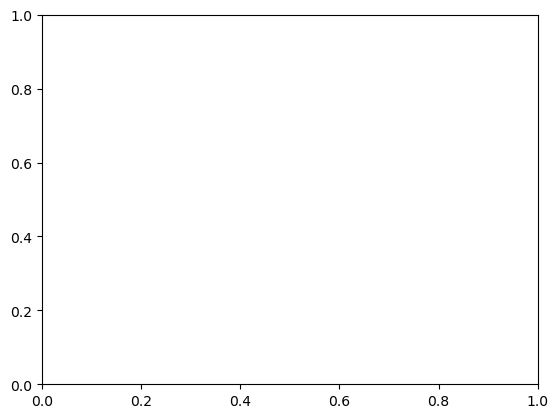

In [455]:
#plot mean distance of network parameters and PDE particles
fig, ax = plt.subplots()
ax.plot(iters, avg_dist_pde_1(iters), c = 'b')
ax.plot(iters, avg_dist_pde_4(iters), c = 'r')
ax.scatter(indices, mean_dist_sgd_1, marker = 'x', c = 'b')
ax.scatter(indices, mean_dist_sgd_4, marker = 'x', c = 'r')
ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Mean Distance')
ax.set_title('Mean PDE vs SGD Distance')
plt.show()

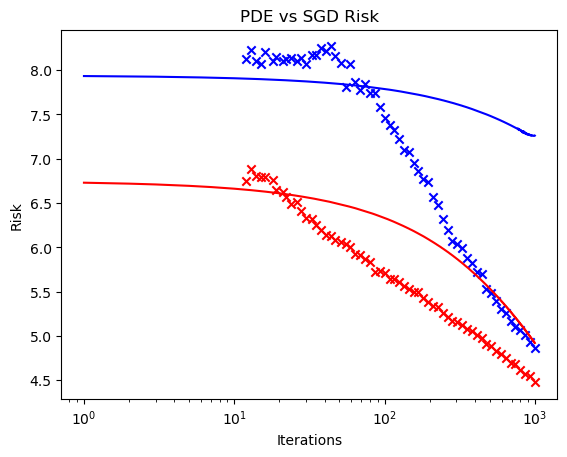

In [453]:
#plot mean risk of network parameters and PDE particles
fig, ax = plt.subplots()
ax.plot(iters, disc_pde_loss_1(iters), c = 'b')
ax.plot(iters, disc_pde_loss_4(iters), c = 'r')
ax.scatter(indices, risk_1, marker = 'x', c = 'b')
ax.scatter(indices, risk_4, marker = 'x', c = 'r')
ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Risk')
ax.set_title('PDE vs SGD Risk')
plt.show()

In [422]:
def stochastic_gradient_descent_1(d, Delta, N, kappa, epsilon = 1e-5, num_epochs = 1000):
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), N).reshape(N, d)
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        sample = random_sample(d,Delta,1)
        X = sample[0].reshape(1,d)
        y = sample[1]
        vgrad = vgrad_sigma_nm(weights@X.T)
        gradient = vgrad.reshape(N,1)*(X).reshape(1,d)
        weights += 2*epsilon**(3/4)*(epoch)**(-0.25)*(y-neural_net_nm(X, weights))*gradient
    
    return weights

In [479]:
d = 320
N = 800
kappa = 0.4
Delta = 0.5
weights = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), N).reshape(N, d)

M = int(5e3)
x_sample, y_sample = random_sample(d, Delta, M)
mse = np.mean((y_sample-neural_net_nm(x_sample,weights))**2)
vals.append(mse)
print('Risk: {}, mean dist: {}'.format(mse, dist))

Risk: 7.288922830796921, mean dist: 0.399630811652345
